In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload
bioqic = mre_pinn.data.BIOQICPhantom('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/phantom')

Loading ../data/BIOQIC/downloads/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
<xarray.Dataset>
Dimensions:    (frequency: 8, t: 8, x: 128, y: 80, z: 25, component: 3)
Coordinates:
  * frequency  (frequency) int64 30 40 50 60 70 80 90 100
  * t          (t) int64 0 1 2 3 4 5 6 7
  * x          (x) float64 0.0 0.0015 0.003 0.0045 ... 0.186 0.1875 0.189 0.1905
  * y          (y) float64 0.0 0.0015 0.003 0.0045 ... 0.114 0.1155 0.117 0.1185
  * z          (z) float64 0.0 0.0015 0.003 0.0045 ... 0.0315 0.033 0.0345 0.036
  * component  (component) <U1 'z' 'x' 'y'
Data variables:
    wave       (frequency, t, x, 

In [4]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/phantom', 80)
example.metadata

Loading ../data/BIOQIC/phantom/80/wave.nc
Loading ../data/BIOQIC/phantom/80/mre.nc
Loading ../data/BIOQIC/phantom/80/mre_mask.nc


size  spacing  origin   limit   center  extent
variable dimension                                                
wave     x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375
mre      x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375
mre_mask x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375

In [5]:
example.describe()

dtype     count                     mean  \
variable component                                                  
wave     z          complex128  256000.0  -0.00007800+0.00006700j   
         x          complex128  256000.0   0.00011600+0.00006000j   
         y          complex128  256000.0   0.00013000-0.00060200j   
mre      scalar     complex128  256000.0  5787.606492+212.755895j   
mre_mask scalar          int64  256000.0   0.61056600+0.00000000j   

                            std                 min                 25%  \
variable component                                                        
wave     z             0.005825 -0.023770+0.001962j -0.002346+0.004141j   
         x             0.006573 -0.021751+0.006846j -0.002244+0.001933j   
         y             0.014630 -0.027802+0.003952j -0.004819+0.001928j   
mre      scalar     5379.844267  0.000000+0.000000j  0.000000+0.000000j   
mre_mask scalar        0.650332  0.000000+0.000000j  0.000000+0.000000j   

                                         50%                       75%  \
variable component                                                       
wave     z         -0.000196000+0.001563000j  0.002125000-0.001518000j   
         x          0.000128000+0.001510000j  0.002530000-0.001175000j   
         y          0.000387000+0.002111000j  0.005085000+0.003413000j   
mre      scalar     10097.662129+358.617637j  10097.662129+358.617637j   
mre_mask scalar     1.000000000+0.000000000j  1.000000000+0.000000000j   

                                          max  
variable component                             
wave     z           0.023069000+0.003372000j  
         x           0.022795000-0.007461000j  
         y           0.028941000-0.005118000j  
mre      scalar     35183.797846+2546.696361j  
mre_mask scalar      5.000000000+0.000000000j

<IPython.core.display.Javascript object>


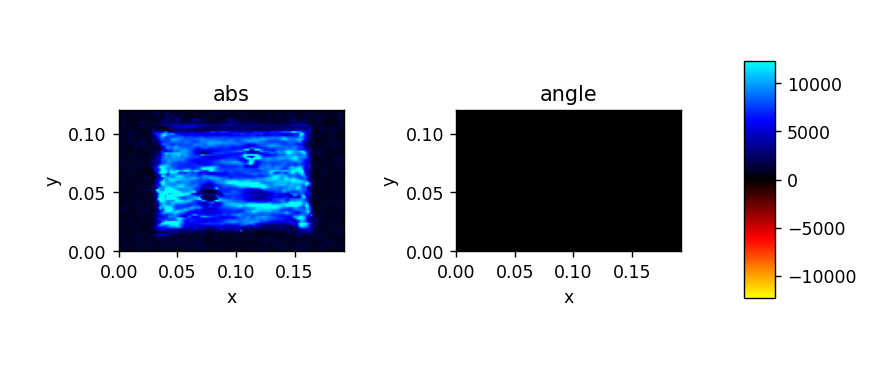

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [6]:
%autoreload
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('base', ax_height=2, ax_width=2, col='part', polar=True)

In [7]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=example.wave.frequency.item(), detach=True)

In [14]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=4,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=2, bias=True)
  )
)

In [15]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_step_iters=1000,
    pde_init_weight=1e-19,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000149 s



In [16]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0009s (1.93%)
Model time/iter: 0.0006s (1.35%)
Loss time/iter:  0.0446s (96.72%)
Total time/iter: 0.0461s
Total time: 4.6116s
1k iters time: 0.77m
10k iters time: 7.69m
100k iters time: 1.28h


<IPython.core.display.Javascript object>


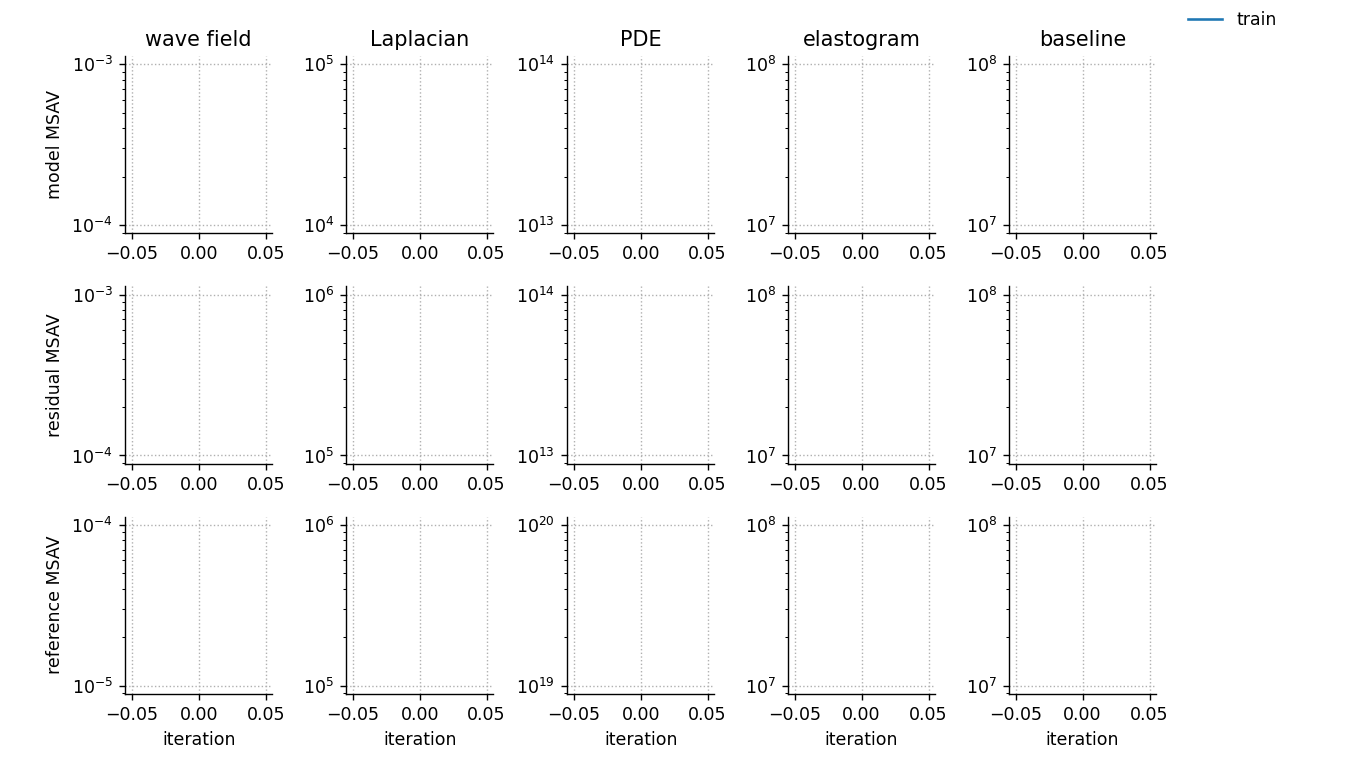

<IPython.core.display.Javascript object>


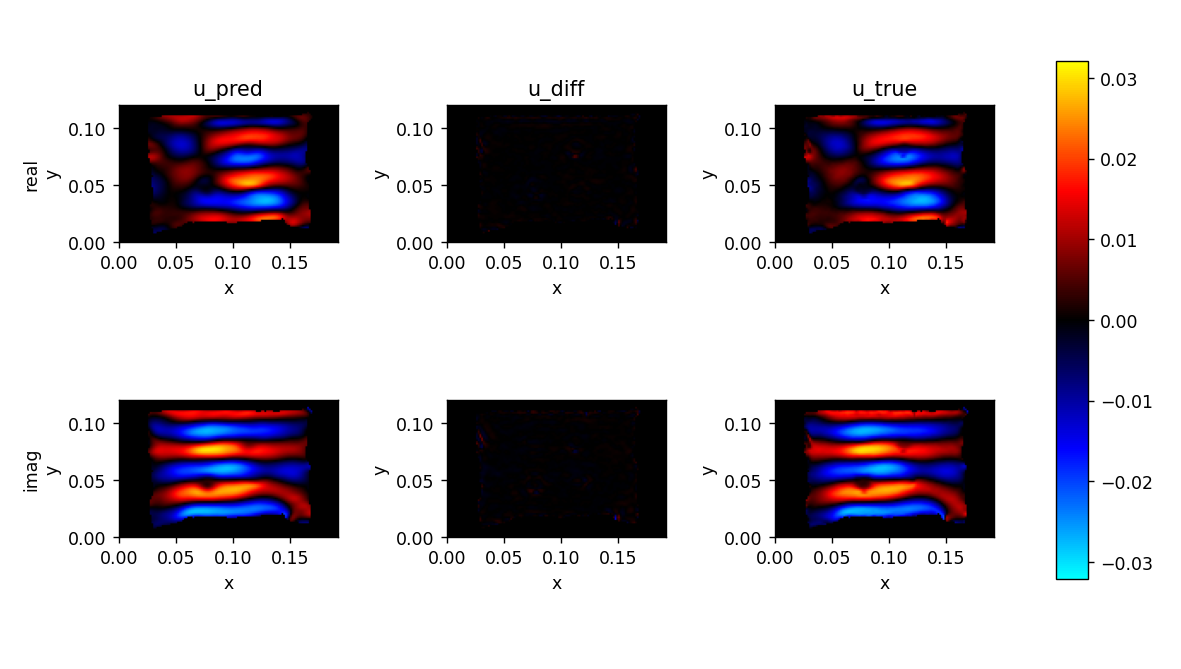

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


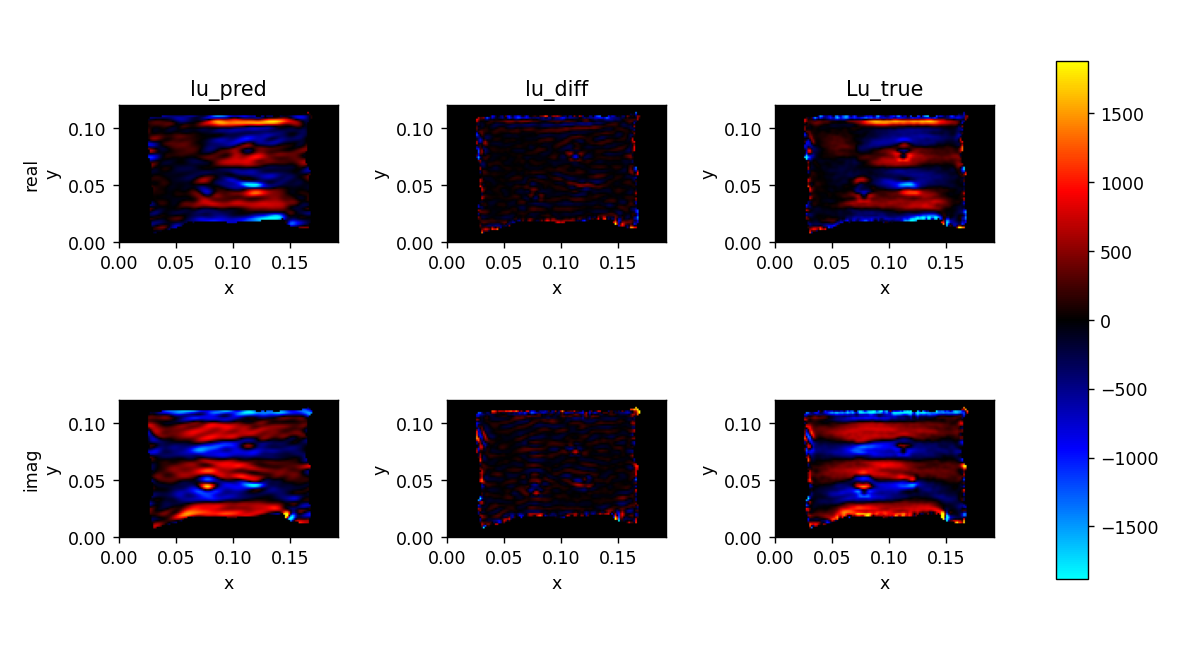

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


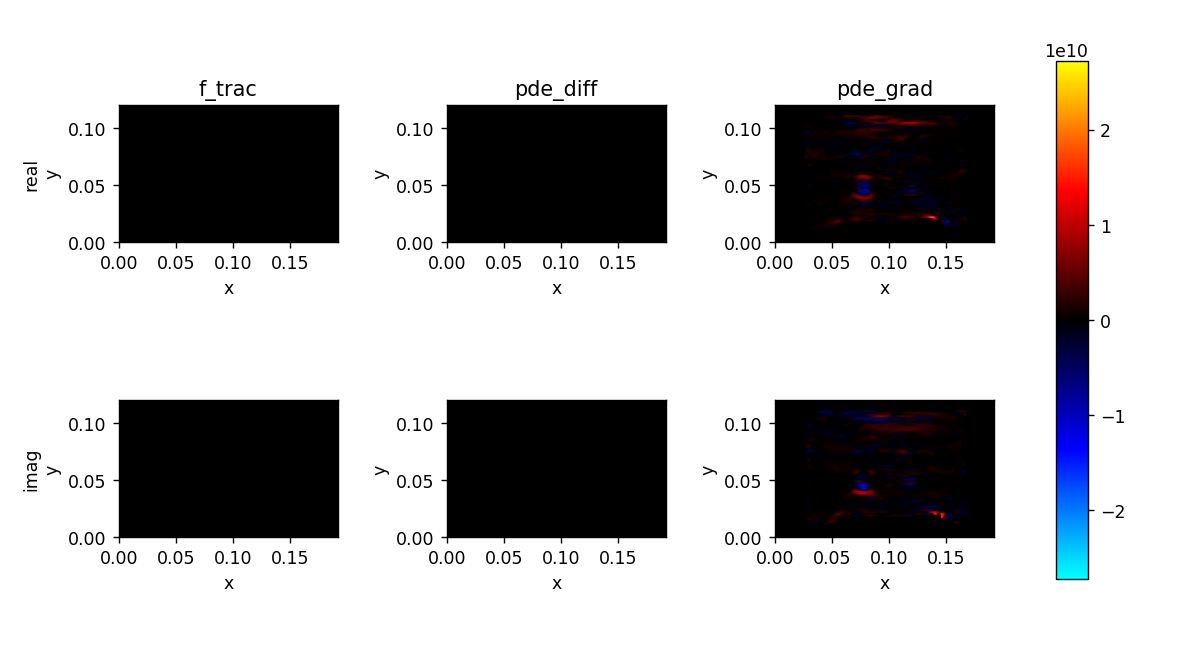

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


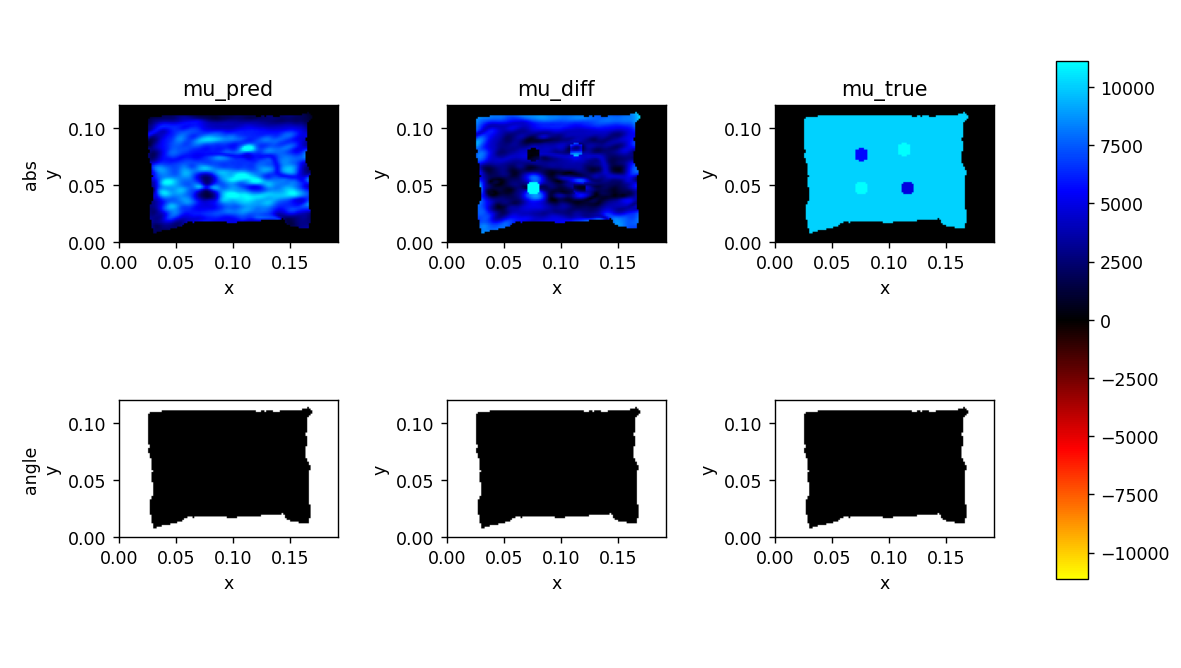

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


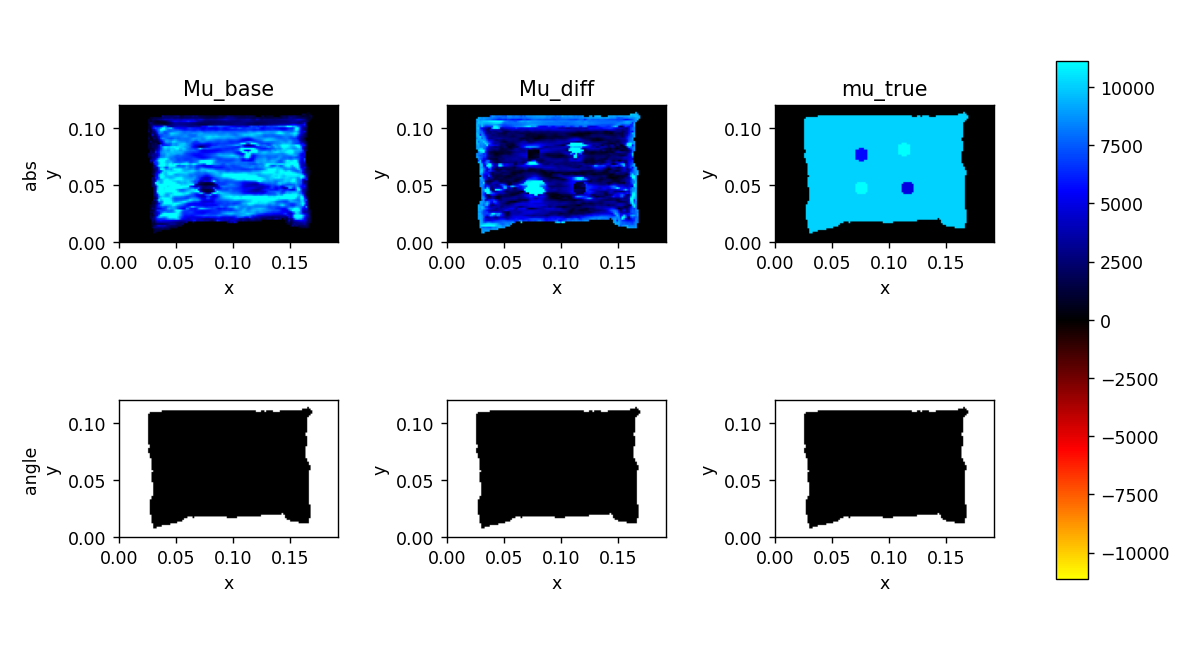

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [17]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

0         [7.26e-04, 0.00e+00, 0.00e+00]    [7.11e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


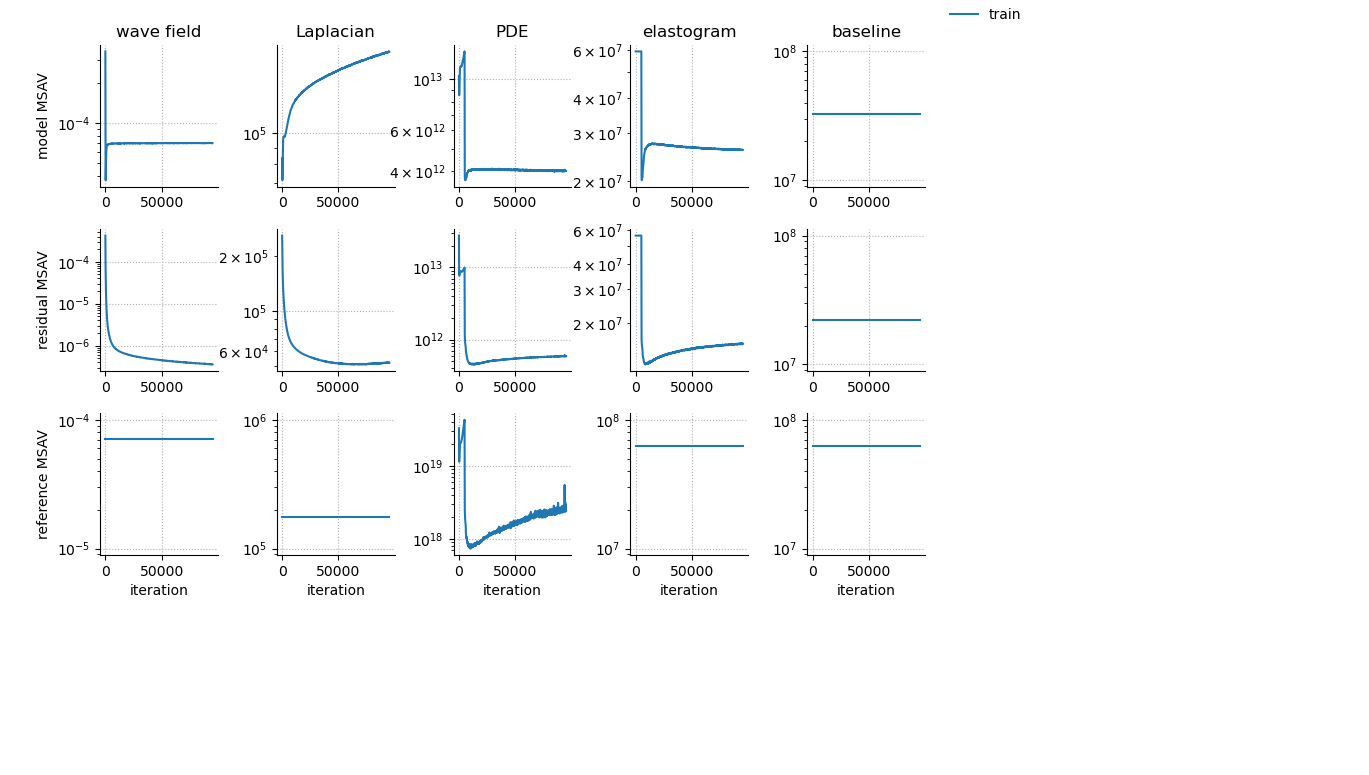

Time spent testing: 37.7199 (29.86%)
10        [6.52e-04, 0.00e+00, 0.00e+00]    [6.25e-04, 0.00e+00, 0.00e+00]    []  
20        [5.78e-04, 0.00e+00, 0.00e+00]    [5.50e-04, 0.00e+00, 0.00e+00]    []  
30        [5.20e-04, 0.00e+00, 0.00e+00]    [4.85e-04, 0.00e+00, 0.00e+00]    []  
40        [4.44e-04, 0.00e+00, 0.00e+00]    [4.30e-04, 0.00e+00, 0.00e+00]    []  
50        [3.97e-04, 0.00e+00, 0.00e+00]    [3.83e-04, 0.00e+00, 0.00e+00]    []  
60        [3.55e-04, 0.00e+00, 0.00e+00]    [3.43e-04, 0.00e+00, 0.00e+00]    []  
70        [3.24e-04, 0.00e+00, 0.00e+00]    [3.10e-04, 0.00e+00, 0.00e+00]    []  
80        [2.89e-04, 0.00e+00, 0.00e+00]    [2.81e-04, 0.00e+00, 0.00e+00]    []  
90        [2.70e-04, 0.00e+00, 0.00e+00]    [2.56e-04, 0.00e+00, 0.00e+00]    []  
100       [2.41e-04, 0.00e+00, 0.00e+00]    [2.35e-04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 36.3915 (43.95%)
110       [2.29e-04, 0.00e+00, 0.00e+00]    [2.17e-04, 0.00e+00, 0.00e+00]    []  
120       [2.

960       [1.46e-05, 0.00e+00, 0.00e+00]    [1.46e-05, 0.00e+00, 0.00e+00]    []  
970       [1.47e-05, 0.00e+00, 0.00e+00]    [1.44e-05, 0.00e+00, 0.00e+00]    []  
980       [1.48e-05, 0.00e+00, 0.00e+00]    [1.41e-05, 0.00e+00, 0.00e+00]    []  
990       [1.42e-05, 0.00e+00, 0.00e+00]    [1.39e-05, 0.00e+00, 0.00e+00]    []  
1000      [1.40e-05, 0.00e+00, 0.00e+00]    [1.37e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.5451 (72.90%)
1010      [1.34e-05, 0.00e+00, 0.00e+00]    [1.35e-05, 0.00e+00, 0.00e+00]    []  
1020      [1.30e-05, 0.00e+00, 0.00e+00]    [1.34e-05, 0.00e+00, 0.00e+00]    []  
1030      [1.35e-05, 0.00e+00, 0.00e+00]    [1.32e-05, 0.00e+00, 0.00e+00]    []  
1040      [1.26e-05, 0.00e+00, 0.00e+00]    [1.30e-05, 0.00e+00, 0.00e+00]    []  
1050      [1.23e-05, 0.00e+00, 0.00e+00]    [1.28e-05, 0.00e+00, 0.00e+00]    []  
1060      [1.27e-05, 0.00e+00, 0.00e+00]    [1.26e-05, 0.00e+00, 0.00e+00]    []  
1070      [1.29e-05, 0.00e+00, 0.00e+00]    [1.25e

Time spent testing: 37.7909 (78.01%)
1910      [5.88e-06, 0.00e+00, 0.00e+00]    [5.80e-06, 0.00e+00, 0.00e+00]    []  
1920      [6.07e-06, 0.00e+00, 0.00e+00]    [5.76e-06, 0.00e+00, 0.00e+00]    []  
1930      [6.12e-06, 0.00e+00, 0.00e+00]    [5.72e-06, 0.00e+00, 0.00e+00]    []  
1940      [5.48e-06, 0.00e+00, 0.00e+00]    [5.69e-06, 0.00e+00, 0.00e+00]    []  
1950      [6.13e-06, 0.00e+00, 0.00e+00]    [5.65e-06, 0.00e+00, 0.00e+00]    []  
1960      [5.76e-06, 0.00e+00, 0.00e+00]    [5.62e-06, 0.00e+00, 0.00e+00]    []  
1970      [5.79e-06, 0.00e+00, 0.00e+00]    [5.59e-06, 0.00e+00, 0.00e+00]    []  
1980      [5.56e-06, 0.00e+00, 0.00e+00]    [5.54e-06, 0.00e+00, 0.00e+00]    []  
1990      [5.31e-06, 0.00e+00, 0.00e+00]    [5.49e-06, 0.00e+00, 0.00e+00]    []  
2000      [5.34e-06, 0.00e+00, 0.00e+00]    [5.47e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.3523 (78.29%)
2010      [5.27e-06, 0.00e+00, 0.00e+00]    [5.45e-06, 0.00e+00, 0.00e+00]    []  
2020      [5.

2860      [3.80e-06, 0.00e+00, 0.00e+00]    [3.65e-06, 0.00e+00, 0.00e+00]    []  
2870      [3.47e-06, 0.00e+00, 0.00e+00]    [3.61e-06, 0.00e+00, 0.00e+00]    []  
2880      [3.58e-06, 0.00e+00, 0.00e+00]    [3.59e-06, 0.00e+00, 0.00e+00]    []  
2890      [3.91e-06, 0.00e+00, 0.00e+00]    [3.58e-06, 0.00e+00, 0.00e+00]    []  
2900      [3.63e-06, 0.00e+00, 0.00e+00]    [3.56e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.6130 (80.24%)
2910      [3.52e-06, 0.00e+00, 0.00e+00]    [3.56e-06, 0.00e+00, 0.00e+00]    []  
2920      [3.27e-06, 0.00e+00, 0.00e+00]    [3.56e-06, 0.00e+00, 0.00e+00]    []  
2930      [3.11e-06, 0.00e+00, 0.00e+00]    [3.53e-06, 0.00e+00, 0.00e+00]    []  
2940      [3.64e-06, 0.00e+00, 0.00e+00]    [3.52e-06, 0.00e+00, 0.00e+00]    []  
2950      [3.58e-06, 0.00e+00, 0.00e+00]    [3.50e-06, 0.00e+00, 0.00e+00]    []  
2960      [3.95e-06, 0.00e+00, 0.00e+00]    [3.47e-06, 0.00e+00, 0.00e+00]    []  
2970      [3.68e-06, 0.00e+00, 0.00e+00]    [3.47e

Time spent testing: 37.6964 (81.36%)
3810      [2.75e-06, 0.00e+00, 0.00e+00]    [2.70e-06, 0.00e+00, 0.00e+00]    []  
3820      [2.92e-06, 0.00e+00, 0.00e+00]    [2.70e-06, 0.00e+00, 0.00e+00]    []  
3830      [2.73e-06, 0.00e+00, 0.00e+00]    [2.69e-06, 0.00e+00, 0.00e+00]    []  
3840      [2.58e-06, 0.00e+00, 0.00e+00]    [2.68e-06, 0.00e+00, 0.00e+00]    []  
3850      [2.69e-06, 0.00e+00, 0.00e+00]    [2.67e-06, 0.00e+00, 0.00e+00]    []  
3860      [2.59e-06, 0.00e+00, 0.00e+00]    [2.67e-06, 0.00e+00, 0.00e+00]    []  
3870      [2.81e-06, 0.00e+00, 0.00e+00]    [2.68e-06, 0.00e+00, 0.00e+00]    []  
3880      [2.65e-06, 0.00e+00, 0.00e+00]    [2.66e-06, 0.00e+00, 0.00e+00]    []  
3890      [2.57e-06, 0.00e+00, 0.00e+00]    [2.64e-06, 0.00e+00, 0.00e+00]    []  
3900      [2.84e-06, 0.00e+00, 0.00e+00]    [2.64e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.7265 (81.45%)
3910      [2.98e-06, 0.00e+00, 0.00e+00]    [2.64e-06, 0.00e+00, 0.00e+00]    []  
3920      [2.

4760      [2.44e-06, 0.00e+00, 0.00e+00]    [2.23e-06, 0.00e+00, 0.00e+00]    []  
4770      [2.52e-06, 0.00e+00, 0.00e+00]    [2.22e-06, 0.00e+00, 0.00e+00]    []  
4780      [2.62e-06, 0.00e+00, 0.00e+00]    [2.21e-06, 0.00e+00, 0.00e+00]    []  
4790      [2.29e-06, 0.00e+00, 0.00e+00]    [2.20e-06, 0.00e+00, 0.00e+00]    []  
4800      [2.57e-06, 0.00e+00, 0.00e+00]    [2.21e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.7526 (82.10%)
4810      [2.27e-06, 0.00e+00, 0.00e+00]    [2.19e-06, 0.00e+00, 0.00e+00]    []  
4820      [2.31e-06, 0.00e+00, 0.00e+00]    [2.18e-06, 0.00e+00, 0.00e+00]    []  
4830      [2.02e-06, 0.00e+00, 0.00e+00]    [2.18e-06, 0.00e+00, 0.00e+00]    []  
4840      [2.16e-06, 0.00e+00, 0.00e+00]    [2.17e-06, 0.00e+00, 0.00e+00]    []  
4850      [2.26e-06, 0.00e+00, 0.00e+00]    [2.18e-06, 0.00e+00, 0.00e+00]    []  
4860      [2.25e-06, 0.00e+00, 0.00e+00]    [2.16e-06, 0.00e+00, 0.00e+00]    []  
4870      [2.00e-06, 0.00e+00, 0.00e+00]    [2.15e

Time spent testing: 38.0470 (82.59%)
5710      [2.20e-06, 0.00e+00, 1.57e-07]    [1.93e-06, 0.00e+00, 1.52e-07]    []  
5720      [1.92e-06, 0.00e+00, 1.53e-07]    [1.92e-06, 0.00e+00, 1.51e-07]    []  
5730      [2.06e-06, 0.00e+00, 1.45e-07]    [1.91e-06, 0.00e+00, 1.51e-07]    []  
5740      [1.78e-06, 0.00e+00, 1.47e-07]    [1.91e-06, 0.00e+00, 1.51e-07]    []  
5750      [1.69e-06, 0.00e+00, 1.47e-07]    [1.90e-06, 0.00e+00, 1.51e-07]    []  
5760      [1.83e-06, 0.00e+00, 1.51e-07]    [1.88e-06, 0.00e+00, 1.51e-07]    []  
5770      [1.92e-06, 0.00e+00, 1.56e-07]    [1.87e-06, 0.00e+00, 1.50e-07]    []  
5780      [2.20e-06, 0.00e+00, 1.54e-07]    [1.86e-06, 0.00e+00, 1.49e-07]    []  
5790      [2.08e-06, 0.00e+00, 1.52e-07]    [1.88e-06, 0.00e+00, 1.49e-07]    []  
5800      [1.98e-06, 0.00e+00, 1.50e-07]    [1.89e-06, 0.00e+00, 1.49e-07]    []  
Time spent testing: 38.3986 (82.60%)
5810      [1.97e-06, 0.00e+00, 1.41e-07]    [1.89e-06, 0.00e+00, 1.48e-07]    []  
5820      [1.

6660      [1.62e-06, 0.00e+00, 1.06e-06]    [1.69e-06, 0.00e+00, 1.09e-06]    []  
6670      [1.73e-06, 0.00e+00, 1.10e-06]    [1.71e-06, 0.00e+00, 1.08e-06]    []  
6680      [1.83e-06, 0.00e+00, 1.06e-06]    [1.70e-06, 0.00e+00, 1.09e-06]    []  
6690      [1.69e-06, 0.00e+00, 1.09e-06]    [1.69e-06, 0.00e+00, 1.08e-06]    []  
6700      [1.83e-06, 0.00e+00, 1.10e-06]    [1.69e-06, 0.00e+00, 1.08e-06]    []  
Time spent testing: 37.8894 (82.97%)
6710      [1.86e-06, 0.00e+00, 1.07e-06]    [1.69e-06, 0.00e+00, 1.08e-06]    []  
6720      [1.88e-06, 0.00e+00, 1.05e-06]    [1.69e-06, 0.00e+00, 1.08e-06]    []  
6730      [2.09e-06, 0.00e+00, 1.06e-06]    [1.70e-06, 0.00e+00, 1.08e-06]    []  
6740      [2.09e-06, 0.00e+00, 1.12e-06]    [1.70e-06, 0.00e+00, 1.08e-06]    []  
6750      [1.61e-06, 0.00e+00, 1.08e-06]    [1.70e-06, 0.00e+00, 1.08e-06]    []  
6760      [1.55e-06, 0.00e+00, 1.03e-06]    [1.68e-06, 0.00e+00, 1.08e-06]    []  
6770      [1.85e-06, 0.00e+00, 1.12e-06]    [1.69e

Time spent testing: 38.2384 (83.25%)
7610      [1.50e-06, 0.00e+00, 9.05e-06]    [1.56e-06, 0.00e+00, 9.12e-06]    []  
7620      [1.55e-06, 0.00e+00, 9.32e-06]    [1.56e-06, 0.00e+00, 9.07e-06]    []  
7630      [1.76e-06, 0.00e+00, 9.07e-06]    [1.56e-06, 0.00e+00, 9.09e-06]    []  
7640      [1.65e-06, 0.00e+00, 9.41e-06]    [1.55e-06, 0.00e+00, 9.19e-06]    []  
7650      [1.56e-06, 0.00e+00, 9.11e-06]    [1.55e-06, 0.00e+00, 9.19e-06]    []  
7660      [1.61e-06, 0.00e+00, 8.96e-06]    [1.56e-06, 0.00e+00, 9.07e-06]    []  
7670      [1.59e-06, 0.00e+00, 9.36e-06]    [1.55e-06, 0.00e+00, 9.10e-06]    []  
7680      [1.44e-06, 0.00e+00, 9.63e-06]    [1.55e-06, 0.00e+00, 9.09e-06]    []  
7690      [1.40e-06, 0.00e+00, 8.77e-06]    [1.54e-06, 0.00e+00, 9.15e-06]    []  
7700      [1.84e-06, 0.00e+00, 9.25e-06]    [1.55e-06, 0.00e+00, 9.17e-06]    []  
Time spent testing: 38.2548 (83.28%)
7710      [1.74e-06, 0.00e+00, 9.21e-06]    [1.55e-06, 0.00e+00, 9.11e-06]    []  
7720      [1.

8560      [1.61e-06, 0.00e+00, 8.23e-05]    [1.46e-06, 0.00e+00, 8.55e-05]    []  
8570      [1.47e-06, 0.00e+00, 9.03e-05]    [1.45e-06, 0.00e+00, 8.54e-05]    []  
8580      [1.62e-06, 0.00e+00, 8.25e-05]    [1.45e-06, 0.00e+00, 8.52e-05]    []  
8590      [1.50e-06, 0.00e+00, 8.41e-05]    [1.45e-06, 0.00e+00, 8.49e-05]    []  
8600      [1.73e-06, 0.00e+00, 9.08e-05]    [1.46e-06, 0.00e+00, 8.56e-05]    []  
Time spent testing: 38.3714 (83.47%)
8610      [1.71e-06, 0.00e+00, 8.69e-05]    [1.46e-06, 0.00e+00, 8.52e-05]    []  
8620      [1.40e-06, 0.00e+00, 8.62e-05]    [1.44e-06, 0.00e+00, 8.48e-05]    []  
8630      [1.60e-06, 0.00e+00, 8.81e-05]    [1.44e-06, 0.00e+00, 8.54e-05]    []  
8640      [1.54e-06, 0.00e+00, 7.63e-05]    [1.45e-06, 0.00e+00, 8.57e-05]    []  
8650      [1.56e-06, 0.00e+00, 8.33e-05]    [1.44e-06, 0.00e+00, 8.48e-05]    []  
8660      [1.26e-06, 0.00e+00, 8.64e-05]    [1.45e-06, 0.00e+00, 8.53e-05]    []  
8670      [1.44e-06, 0.00e+00, 7.88e-05]    [1.45e

Time spent testing: 38.3355 (83.65%)
9510      [1.46e-06, 0.00e+00, 8.36e-04]    [1.41e-06, 0.00e+00, 8.38e-04]    []  
9520      [1.36e-06, 0.00e+00, 8.16e-04]    [1.41e-06, 0.00e+00, 8.45e-04]    []  
9530      [1.37e-06, 0.00e+00, 8.44e-04]    [1.41e-06, 0.00e+00, 8.56e-04]    []  
9540      [1.52e-06, 0.00e+00, 7.77e-04]    [1.41e-06, 0.00e+00, 8.42e-04]    []  
9550      [1.70e-06, 0.00e+00, 7.87e-04]    [1.41e-06, 0.00e+00, 8.36e-04]    []  
9560      [1.52e-06, 0.00e+00, 7.94e-04]    [1.41e-06, 0.00e+00, 8.30e-04]    []  
9570      [1.48e-06, 0.00e+00, 8.13e-04]    [1.40e-06, 0.00e+00, 8.26e-04]    []  
9580      [1.36e-06, 0.00e+00, 8.00e-04]    [1.40e-06, 0.00e+00, 8.18e-04]    []  
9590      [1.28e-06, 0.00e+00, 8.27e-04]    [1.39e-06, 0.00e+00, 8.30e-04]    []  
9600      [1.43e-06, 0.00e+00, 7.94e-04]    [1.38e-06, 0.00e+00, 8.36e-04]    []  
Time spent testing: 38.1419 (83.67%)
9610      [1.45e-06, 0.00e+00, 8.36e-04]    [1.40e-06, 0.00e+00, 8.40e-04]    []  
9620      [1.

10460     [1.22e-06, 0.00e+00, 8.33e-03]    [1.33e-06, 0.00e+00, 8.13e-03]    []  
10470     [1.49e-06, 0.00e+00, 7.60e-03]    [1.32e-06, 0.00e+00, 8.18e-03]    []  
10480     [1.52e-06, 0.00e+00, 7.85e-03]    [1.32e-06, 0.00e+00, 8.19e-03]    []  
10490     [1.57e-06, 0.00e+00, 7.68e-03]    [1.33e-06, 0.00e+00, 8.12e-03]    []  
10500     [1.30e-06, 0.00e+00, 7.95e-03]    [1.34e-06, 0.00e+00, 8.17e-03]    []  
Time spent testing: 38.5217 (83.80%)
10510     [1.40e-06, 0.00e+00, 8.02e-03]    [1.33e-06, 0.00e+00, 8.15e-03]    []  
10520     [1.49e-06, 0.00e+00, 7.80e-03]    [1.33e-06, 0.00e+00, 8.21e-03]    []  
10530     [1.56e-06, 0.00e+00, 7.54e-03]    [1.32e-06, 0.00e+00, 8.26e-03]    []  
10540     [1.73e-06, 0.00e+00, 7.87e-03]    [1.33e-06, 0.00e+00, 8.24e-03]    []  
10550     [1.31e-06, 0.00e+00, 7.55e-03]    [1.31e-06, 0.00e+00, 8.11e-03]    []  
10560     [1.18e-06, 0.00e+00, 8.01e-03]    [1.30e-06, 0.00e+00, 8.16e-03]    []  
10570     [1.48e-06, 0.00e+00, 8.08e-03]    [1.30e

Time spent testing: 38.8533 (83.93%)
11410     [1.33e-06, 0.00e+00, 8.07e-02]    [1.30e-06, 0.00e+00, 8.32e-02]    []  
11420     [1.18e-06, 0.00e+00, 7.66e-02]    [1.29e-06, 0.00e+00, 8.22e-02]    []  
11430     [1.58e-06, 0.00e+00, 7.94e-02]    [1.28e-06, 0.00e+00, 8.25e-02]    []  
11440     [1.24e-06, 0.00e+00, 7.68e-02]    [1.27e-06, 0.00e+00, 8.24e-02]    []  
11450     [1.46e-06, 0.00e+00, 8.08e-02]    [1.27e-06, 0.00e+00, 8.21e-02]    []  
11460     [1.43e-06, 0.00e+00, 7.82e-02]    [1.28e-06, 0.00e+00, 8.21e-02]    []  
11470     [1.48e-06, 0.00e+00, 8.23e-02]    [1.27e-06, 0.00e+00, 8.14e-02]    []  
11480     [1.38e-06, 0.00e+00, 7.97e-02]    [1.28e-06, 0.00e+00, 8.17e-02]    []  
11490     [1.30e-06, 0.00e+00, 7.87e-02]    [1.28e-06, 0.00e+00, 8.18e-02]    []  
11500     [1.27e-06, 0.00e+00, 8.03e-02]    [1.30e-06, 0.00e+00, 8.20e-02]    []  
Time spent testing: 38.3689 (83.94%)
11510     [1.23e-06, 0.00e+00, 7.48e-02]    [1.26e-06, 0.00e+00, 8.09e-02]    []  
11520     [1.

12360     [1.45e-06, 0.00e+00, 7.72e-01]    [1.23e-06, 0.00e+00, 8.12e-01]    []  
12370     [1.27e-06, 0.00e+00, 8.25e-01]    [1.24e-06, 0.00e+00, 8.26e-01]    []  
12380     [1.29e-06, 0.00e+00, 8.63e-01]    [1.23e-06, 0.00e+00, 8.19e-01]    []  
12390     [1.32e-06, 0.00e+00, 7.97e-01]    [1.22e-06, 0.00e+00, 8.23e-01]    []  
12400     [1.24e-06, 0.00e+00, 7.56e-01]    [1.23e-06, 0.00e+00, 8.23e-01]    []  
Time spent testing: 38.6509 (84.04%)
12410     [1.41e-06, 0.00e+00, 8.10e-01]    [1.23e-06, 0.00e+00, 8.28e-01]    []  
12420     [1.40e-06, 0.00e+00, 8.64e-01]    [1.22e-06, 0.00e+00, 8.25e-01]    []  
12430     [1.07e-06, 0.00e+00, 7.63e-01]    [1.23e-06, 0.00e+00, 8.27e-01]    []  
12440     [1.22e-06, 0.00e+00, 7.50e-01]    [1.22e-06, 0.00e+00, 8.18e-01]    []  
12450     [1.35e-06, 0.00e+00, 7.98e-01]    [1.22e-06, 0.00e+00, 8.22e-01]    []  
12460     [1.31e-06, 0.00e+00, 7.91e-01]    [1.22e-06, 0.00e+00, 8.27e-01]    []  
12470     [1.16e-06, 0.00e+00, 7.92e-01]    [1.22e

Time spent testing: 38.0534 (84.13%)
13310     [1.36e-06, 0.00e+00, 8.21e+00]    [1.20e-06, 0.00e+00, 8.28e+00]    []  
13320     [1.12e-06, 0.00e+00, 8.70e+00]    [1.20e-06, 0.00e+00, 8.19e+00]    []  
13330     [1.39e-06, 0.00e+00, 8.05e+00]    [1.20e-06, 0.00e+00, 8.22e+00]    []  
13340     [1.13e-06, 0.00e+00, 7.93e+00]    [1.18e-06, 0.00e+00, 8.21e+00]    []  
13350     [1.08e-06, 0.00e+00, 7.82e+00]    [1.19e-06, 0.00e+00, 8.16e+00]    []  
13360     [1.32e-06, 0.00e+00, 7.76e+00]    [1.20e-06, 0.00e+00, 8.23e+00]    []  
13370     [1.10e-06, 0.00e+00, 7.93e+00]    [1.18e-06, 0.00e+00, 8.23e+00]    []  
13380     [1.17e-06, 0.00e+00, 8.47e+00]    [1.18e-06, 0.00e+00, 8.23e+00]    []  
13390     [1.13e-06, 0.00e+00, 7.72e+00]    [1.18e-06, 0.00e+00, 8.23e+00]    []  
13400     [1.24e-06, 0.00e+00, 8.03e+00]    [1.20e-06, 0.00e+00, 8.27e+00]    []  
Time spent testing: 38.3339 (84.14%)
13410     [1.25e-06, 0.00e+00, 7.50e+00]    [1.20e-06, 0.00e+00, 8.20e+00]    []  
13420     [1.

14260     [1.27e-06, 0.00e+00, 8.28e+01]    [1.17e-06, 0.00e+00, 8.30e+01]    []  
14270     [1.26e-06, 0.00e+00, 7.57e+01]    [1.17e-06, 0.00e+00, 8.15e+01]    []  
14280     [1.18e-06, 0.00e+00, 7.89e+01]    [1.17e-06, 0.00e+00, 8.17e+01]    []  
14290     [1.25e-06, 0.00e+00, 7.90e+01]    [1.16e-06, 0.00e+00, 8.16e+01]    []  
14300     [1.41e-06, 0.00e+00, 7.83e+01]    [1.16e-06, 0.00e+00, 8.14e+01]    []  
Time spent testing: 38.6060 (84.21%)
14310     [1.34e-06, 0.00e+00, 7.65e+01]    [1.16e-06, 0.00e+00, 8.15e+01]    []  
14320     [1.30e-06, 0.00e+00, 8.04e+01]    [1.14e-06, 0.00e+00, 8.11e+01]    []  
14330     [1.16e-06, 0.00e+00, 7.92e+01]    [1.15e-06, 0.00e+00, 8.27e+01]    []  
14340     [1.11e-06, 0.00e+00, 7.55e+01]    [1.15e-06, 0.00e+00, 8.22e+01]    []  
14350     [1.47e-06, 0.00e+00, 8.22e+01]    [1.15e-06, 0.00e+00, 8.22e+01]    []  
14360     [1.11e-06, 0.00e+00, 8.32e+01]    [1.16e-06, 0.00e+00, 8.20e+01]    []  
14370     [1.11e-06, 0.00e+00, 8.38e+01]    [1.16e

Time spent testing: 38.4355 (84.29%)
15210     [1.14e-06, 0.00e+00, 8.14e+02]    [1.16e-06, 0.00e+00, 8.32e+02]    []  
15220     [1.32e-06, 0.00e+00, 8.21e+02]    [1.14e-06, 0.00e+00, 8.16e+02]    []  
15230     [1.08e-06, 0.00e+00, 7.38e+02]    [1.13e-06, 0.00e+00, 8.04e+02]    []  
15240     [1.10e-06, 0.00e+00, 7.80e+02]    [1.12e-06, 0.00e+00, 8.10e+02]    []  
15250     [9.62e-07, 0.00e+00, 7.55e+02]    [1.13e-06, 0.00e+00, 8.10e+02]    []  
15260     [1.26e-06, 0.00e+00, 7.83e+02]    [1.13e-06, 0.00e+00, 8.16e+02]    []  
15270     [1.37e-06, 0.00e+00, 7.91e+02]    [1.14e-06, 0.00e+00, 8.27e+02]    []  
15280     [1.29e-06, 0.00e+00, 8.49e+02]    [1.14e-06, 0.00e+00, 8.14e+02]    []  
15290     [1.18e-06, 0.00e+00, 8.81e+02]    [1.14e-06, 0.00e+00, 8.19e+02]    []  
15300     [1.21e-06, 0.00e+00, 8.93e+02]    [1.14e-06, 0.00e+00, 8.13e+02]    []  
Time spent testing: 38.8022 (84.29%)
15310     [1.10e-06, 0.00e+00, 8.35e+02]    [1.13e-06, 0.00e+00, 8.16e+02]    []  
15320     [1.

16160     [1.13e-06, 0.00e+00, 7.31e+03]    [1.11e-06, 0.00e+00, 8.16e+03]    []  
16170     [1.20e-06, 0.00e+00, 8.96e+03]    [1.11e-06, 0.00e+00, 8.17e+03]    []  
16180     [1.16e-06, 0.00e+00, 7.84e+03]    [1.12e-06, 0.00e+00, 8.21e+03]    []  
16190     [1.03e-06, 0.00e+00, 7.98e+03]    [1.09e-06, 0.00e+00, 8.14e+03]    []  
16200     [1.16e-06, 0.00e+00, 8.13e+03]    [1.10e-06, 0.00e+00, 8.05e+03]    []  
Time spent testing: 38.1972 (84.35%)
16210     [1.25e-06, 0.00e+00, 7.83e+03]    [1.11e-06, 0.00e+00, 8.14e+03]    []  
16220     [1.01e-06, 0.00e+00, 8.12e+03]    [1.12e-06, 0.00e+00, 8.14e+03]    []  
16230     [1.19e-06, 0.00e+00, 8.12e+03]    [1.11e-06, 0.00e+00, 8.16e+03]    []  
16240     [1.12e-06, 0.00e+00, 8.36e+03]    [1.11e-06, 0.00e+00, 8.23e+03]    []  
16250     [1.04e-06, 0.00e+00, 7.86e+03]    [1.10e-06, 0.00e+00, 8.22e+03]    []  
16260     [1.08e-06, 0.00e+00, 8.15e+03]    [1.10e-06, 0.00e+00, 8.21e+03]    []  
16270     [1.19e-06, 0.00e+00, 7.59e+03]    [1.10e

Time spent testing: 38.3640 (84.40%)
17110     [1.30e-06, 0.00e+00, 7.38e+03]    [1.09e-06, 0.00e+00, 8.18e+03]    []  
17120     [9.28e-07, 0.00e+00, 7.87e+03]    [1.09e-06, 0.00e+00, 8.14e+03]    []  
17130     [1.37e-06, 0.00e+00, 7.76e+03]    [1.08e-06, 0.00e+00, 8.09e+03]    []  
17140     [1.05e-06, 0.00e+00, 8.73e+03]    [1.08e-06, 0.00e+00, 8.02e+03]    []  
17150     [1.29e-06, 0.00e+00, 8.32e+03]    [1.09e-06, 0.00e+00, 8.10e+03]    []  
17160     [1.14e-06, 0.00e+00, 8.04e+03]    [1.09e-06, 0.00e+00, 8.12e+03]    []  
17170     [1.22e-06, 0.00e+00, 7.95e+03]    [1.09e-06, 0.00e+00, 8.12e+03]    []  
17180     [1.09e-06, 0.00e+00, 8.59e+03]    [1.09e-06, 0.00e+00, 8.21e+03]    []  
17190     [1.08e-06, 0.00e+00, 8.10e+03]    [1.08e-06, 0.00e+00, 8.21e+03]    []  
17200     [1.28e-06, 0.00e+00, 8.15e+03]    [1.09e-06, 0.00e+00, 8.13e+03]    []  
Time spent testing: 39.0543 (84.41%)
17210     [1.08e-06, 0.00e+00, 7.93e+03]    [1.07e-06, 0.00e+00, 8.04e+03]    []  
17220     [1.

18060     [1.22e-06, 0.00e+00, 8.14e+03]    [1.06e-06, 0.00e+00, 8.06e+03]    []  
18070     [1.17e-06, 0.00e+00, 8.52e+03]    [1.07e-06, 0.00e+00, 8.06e+03]    []  
18080     [1.10e-06, 0.00e+00, 8.42e+03]    [1.06e-06, 0.00e+00, 8.10e+03]    []  
18090     [1.13e-06, 0.00e+00, 8.16e+03]    [1.06e-06, 0.00e+00, 8.08e+03]    []  
18100     [1.03e-06, 0.00e+00, 7.83e+03]    [1.07e-06, 0.00e+00, 8.10e+03]    []  
Time spent testing: 39.0061 (84.46%)
18110     [9.75e-07, 0.00e+00, 8.03e+03]    [1.07e-06, 0.00e+00, 8.13e+03]    []  
18120     [1.24e-06, 0.00e+00, 8.10e+03]    [1.06e-06, 0.00e+00, 8.22e+03]    []  
18130     [1.16e-06, 0.00e+00, 7.44e+03]    [1.06e-06, 0.00e+00, 8.16e+03]    []  
18140     [1.06e-06, 0.00e+00, 7.63e+03]    [1.07e-06, 0.00e+00, 8.16e+03]    []  
18150     [1.24e-06, 0.00e+00, 8.26e+03]    [1.07e-06, 0.00e+00, 8.21e+03]    []  
18160     [1.12e-06, 0.00e+00, 7.97e+03]    [1.06e-06, 0.00e+00, 8.15e+03]    []  
18170     [1.28e-06, 0.00e+00, 8.38e+03]    [1.05e

Time spent testing: 38.9808 (84.51%)
19010     [1.01e-06, 0.00e+00, 8.35e+03]    [1.04e-06, 0.00e+00, 8.21e+03]    []  
19020     [1.30e-06, 0.00e+00, 8.26e+03]    [1.03e-06, 0.00e+00, 8.15e+03]    []  
19030     [9.50e-07, 0.00e+00, 8.98e+03]    [1.04e-06, 0.00e+00, 8.13e+03]    []  
19040     [1.19e-06, 0.00e+00, 8.62e+03]    [1.04e-06, 0.00e+00, 8.16e+03]    []  
19050     [1.04e-06, 0.00e+00, 7.99e+03]    [1.03e-06, 0.00e+00, 8.21e+03]    []  
19060     [1.05e-06, 0.00e+00, 7.96e+03]    [1.02e-06, 0.00e+00, 8.15e+03]    []  
19070     [1.17e-06, 0.00e+00, 8.20e+03]    [1.03e-06, 0.00e+00, 8.13e+03]    []  
19080     [1.22e-06, 0.00e+00, 8.75e+03]    [1.04e-06, 0.00e+00, 8.20e+03]    []  
19090     [1.14e-06, 0.00e+00, 7.64e+03]    [1.05e-06, 0.00e+00, 8.17e+03]    []  
19100     [1.06e-06, 0.00e+00, 8.36e+03]    [1.04e-06, 0.00e+00, 8.20e+03]    []  
Time spent testing: 39.1041 (84.51%)
19110     [1.28e-06, 0.00e+00, 8.88e+03]    [1.02e-06, 0.00e+00, 8.29e+03]    []  
19120     [1.

19960     [8.70e-07, 0.00e+00, 8.36e+03]    [1.03e-06, 0.00e+00, 8.22e+03]    []  
19970     [1.15e-06, 0.00e+00, 9.47e+03]    [1.04e-06, 0.00e+00, 8.18e+03]    []  
19980     [1.10e-06, 0.00e+00, 8.14e+03]    [1.03e-06, 0.00e+00, 8.22e+03]    []  
19990     [1.14e-06, 0.00e+00, 8.43e+03]    [1.04e-06, 0.00e+00, 8.15e+03]    []  
20000     [1.05e-06, 0.00e+00, 8.48e+03]    [1.04e-06, 0.00e+00, 8.16e+03]    []  
Time spent testing: 39.0000 (84.56%)
20010     [1.13e-06, 0.00e+00, 8.21e+03]    [1.03e-06, 0.00e+00, 8.14e+03]    []  
20020     [9.61e-07, 0.00e+00, 9.36e+03]    [1.02e-06, 0.00e+00, 8.16e+03]    []  
20030     [9.41e-07, 0.00e+00, 7.92e+03]    [1.03e-06, 0.00e+00, 8.24e+03]    []  
20040     [9.76e-07, 0.00e+00, 8.75e+03]    [1.03e-06, 0.00e+00, 8.25e+03]    []  
20050     [9.73e-07, 0.00e+00, 8.24e+03]    [1.02e-06, 0.00e+00, 8.17e+03]    []  
20060     [1.10e-06, 0.00e+00, 9.20e+03]    [1.03e-06, 0.00e+00, 8.10e+03]    []  
20070     [8.17e-07, 0.00e+00, 8.70e+03]    [1.05e

Time spent testing: 39.0581 (84.59%)
20910     [1.06e-06, 0.00e+00, 8.54e+03]    [1.01e-06, 0.00e+00, 8.33e+03]    []  
20920     [1.25e-06, 0.00e+00, 8.74e+03]    [1.01e-06, 0.00e+00, 8.37e+03]    []  
20930     [1.03e-06, 0.00e+00, 8.18e+03]    [9.98e-07, 0.00e+00, 8.27e+03]    []  
20940     [1.07e-06, 0.00e+00, 8.24e+03]    [9.95e-07, 0.00e+00, 8.15e+03]    []  
20950     [8.35e-07, 0.00e+00, 7.93e+03]    [9.98e-07, 0.00e+00, 8.15e+03]    []  
20960     [9.69e-07, 0.00e+00, 7.65e+03]    [9.97e-07, 0.00e+00, 8.26e+03]    []  
20970     [1.14e-06, 0.00e+00, 8.38e+03]    [1.01e-06, 0.00e+00, 8.25e+03]    []  
20980     [9.79e-07, 0.00e+00, 7.69e+03]    [1.01e-06, 0.00e+00, 8.33e+03]    []  
20990     [9.45e-07, 0.00e+00, 8.18e+03]    [1.01e-06, 0.00e+00, 8.37e+03]    []  
21000     [1.15e-06, 0.00e+00, 8.64e+03]    [9.99e-07, 0.00e+00, 8.37e+03]    []  
Time spent testing: 38.7574 (84.60%)
21010     [1.17e-06, 0.00e+00, 8.25e+03]    [9.96e-07, 0.00e+00, 8.36e+03]    []  
21020     [1.

21860     [1.10e-06, 0.00e+00, 8.94e+03]    [1.00e-06, 0.00e+00, 8.31e+03]    []  
21870     [1.29e-06, 0.00e+00, 8.59e+03]    [1.01e-06, 0.00e+00, 8.33e+03]    []  
21880     [9.51e-07, 0.00e+00, 7.90e+03]    [1.01e-06, 0.00e+00, 8.38e+03]    []  
21890     [9.09e-07, 0.00e+00, 8.42e+03]    [9.96e-07, 0.00e+00, 8.47e+03]    []  
21900     [1.27e-06, 0.00e+00, 8.47e+03]    [1.01e-06, 0.00e+00, 8.44e+03]    []  
Time spent testing: 39.0107 (84.64%)
21910     [1.06e-06, 0.00e+00, 8.84e+03]    [1.01e-06, 0.00e+00, 8.38e+03]    []  
21920     [9.25e-07, 0.00e+00, 8.38e+03]    [1.01e-06, 0.00e+00, 8.46e+03]    []  
21930     [9.85e-07, 0.00e+00, 8.07e+03]    [1.01e-06, 0.00e+00, 8.44e+03]    []  
21940     [1.01e-06, 0.00e+00, 8.43e+03]    [9.96e-07, 0.00e+00, 8.40e+03]    []  
21950     [1.25e-06, 0.00e+00, 8.31e+03]    [1.00e-06, 0.00e+00, 8.38e+03]    []  
21960     [1.24e-06, 0.00e+00, 8.52e+03]    [9.97e-07, 0.00e+00, 8.32e+03]    []  
21970     [1.12e-06, 0.00e+00, 8.69e+03]    [1.00e

Time spent testing: 38.8210 (84.66%)
22810     [1.18e-06, 0.00e+00, 8.36e+03]    [9.81e-07, 0.00e+00, 8.25e+03]    []  
22820     [9.13e-07, 0.00e+00, 8.03e+03]    [9.93e-07, 0.00e+00, 8.25e+03]    []  
22830     [9.10e-07, 0.00e+00, 8.36e+03]    [9.92e-07, 0.00e+00, 8.25e+03]    []  
22840     [1.09e-06, 0.00e+00, 8.59e+03]    [9.83e-07, 0.00e+00, 8.33e+03]    []  
22850     [1.06e-06, 0.00e+00, 8.42e+03]    [9.85e-07, 0.00e+00, 8.30e+03]    []  
22860     [1.17e-06, 0.00e+00, 9.31e+03]    [9.86e-07, 0.00e+00, 8.35e+03]    []  
22870     [1.09e-06, 0.00e+00, 8.48e+03]    [9.82e-07, 0.00e+00, 8.35e+03]    []  
22880     [1.17e-06, 0.00e+00, 8.87e+03]    [9.75e-07, 0.00e+00, 8.35e+03]    []  
22890     [1.18e-06, 0.00e+00, 8.47e+03]    [9.80e-07, 0.00e+00, 8.36e+03]    []  
22900     [1.03e-06, 0.00e+00, 8.20e+03]    [9.85e-07, 0.00e+00, 8.45e+03]    []  
Time spent testing: 39.0098 (84.67%)
22910     [9.79e-07, 0.00e+00, 9.03e+03]    [9.98e-07, 0.00e+00, 8.48e+03]    []  
22920     [1.

23760     [1.27e-06, 0.00e+00, 8.29e+03]    [9.61e-07, 0.00e+00, 8.45e+03]    []  
23770     [9.98e-07, 0.00e+00, 8.63e+03]    [9.64e-07, 0.00e+00, 8.47e+03]    []  
23780     [1.19e-06, 0.00e+00, 7.97e+03]    [9.58e-07, 0.00e+00, 8.51e+03]    []  
23790     [1.14e-06, 0.00e+00, 9.64e+03]    [9.78e-07, 0.00e+00, 8.51e+03]    []  
23800     [9.43e-07, 0.00e+00, 8.27e+03]    [9.67e-07, 0.00e+00, 8.46e+03]    []  
Time spent testing: 39.1861 (84.70%)
23810     [1.25e-06, 0.00e+00, 9.34e+03]    [9.77e-07, 0.00e+00, 8.43e+03]    []  
23820     [9.68e-07, 0.00e+00, 9.27e+03]    [9.75e-07, 0.00e+00, 8.36e+03]    []  
23830     [9.44e-07, 0.00e+00, 7.94e+03]    [9.92e-07, 0.00e+00, 8.39e+03]    []  
23840     [9.72e-07, 0.00e+00, 8.82e+03]    [9.79e-07, 0.00e+00, 8.38e+03]    []  
23850     [1.02e-06, 0.00e+00, 8.71e+03]    [9.68e-07, 0.00e+00, 8.43e+03]    []  
23860     [1.07e-06, 0.00e+00, 8.98e+03]    [9.68e-07, 0.00e+00, 8.49e+03]    []  
23870     [1.25e-06, 0.00e+00, 8.92e+03]    [9.71e

Time spent testing: 39.2223 (84.73%)
24710     [1.13e-06, 0.00e+00, 8.90e+03]    [9.57e-07, 0.00e+00, 8.42e+03]    []  
24720     [1.10e-06, 0.00e+00, 1.00e+04]    [9.61e-07, 0.00e+00, 8.40e+03]    []  
24730     [9.06e-07, 0.00e+00, 8.69e+03]    [9.67e-07, 0.00e+00, 8.33e+03]    []  
24740     [8.58e-07, 0.00e+00, 8.43e+03]    [9.73e-07, 0.00e+00, 8.34e+03]    []  
24750     [1.10e-06, 0.00e+00, 8.81e+03]    [9.67e-07, 0.00e+00, 8.41e+03]    []  
24760     [8.93e-07, 0.00e+00, 8.78e+03]    [9.54e-07, 0.00e+00, 8.32e+03]    []  
24770     [8.72e-07, 0.00e+00, 8.12e+03]    [9.69e-07, 0.00e+00, 8.33e+03]    []  
24780     [1.18e-06, 0.00e+00, 8.95e+03]    [9.61e-07, 0.00e+00, 8.30e+03]    []  
24790     [1.06e-06, 0.00e+00, 8.38e+03]    [9.58e-07, 0.00e+00, 8.32e+03]    []  
24800     [9.37e-07, 0.00e+00, 9.29e+03]    [9.57e-07, 0.00e+00, 8.39e+03]    []  
Time spent testing: 38.5593 (84.74%)
24810     [9.21e-07, 0.00e+00, 8.22e+03]    [9.61e-07, 0.00e+00, 8.37e+03]    []  
24820     [8.

25660     [1.05e-06, 0.00e+00, 8.31e+03]    [9.29e-07, 0.00e+00, 8.50e+03]    []  
25670     [9.32e-07, 0.00e+00, 8.29e+03]    [9.33e-07, 0.00e+00, 8.50e+03]    []  
25680     [8.31e-07, 0.00e+00, 8.47e+03]    [9.41e-07, 0.00e+00, 8.56e+03]    []  
25690     [1.07e-06, 0.00e+00, 8.91e+03]    [9.45e-07, 0.00e+00, 8.54e+03]    []  
25700     [1.04e-06, 0.00e+00, 9.10e+03]    [9.39e-07, 0.00e+00, 8.53e+03]    []  
Time spent testing: 39.1787 (84.76%)
25710     [9.64e-07, 0.00e+00, 8.41e+03]    [9.51e-07, 0.00e+00, 8.58e+03]    []  
25720     [9.16e-07, 0.00e+00, 8.79e+03]    [9.56e-07, 0.00e+00, 8.53e+03]    []  
25730     [1.06e-06, 0.00e+00, 8.64e+03]    [9.52e-07, 0.00e+00, 8.50e+03]    []  
25740     [1.08e-06, 0.00e+00, 8.08e+03]    [9.55e-07, 0.00e+00, 8.47e+03]    []  
25750     [9.52e-07, 0.00e+00, 8.47e+03]    [9.46e-07, 0.00e+00, 8.44e+03]    []  
25760     [1.02e-06, 0.00e+00, 8.68e+03]    [9.51e-07, 0.00e+00, 8.48e+03]    []  
25770     [1.05e-06, 0.00e+00, 8.41e+03]    [9.45e

Time spent testing: 39.0253 (84.79%)
26610     [8.56e-07, 0.00e+00, 8.60e+03]    [9.42e-07, 0.00e+00, 8.49e+03]    []  
26620     [1.06e-06, 0.00e+00, 9.05e+03]    [9.42e-07, 0.00e+00, 8.60e+03]    []  
26630     [9.51e-07, 0.00e+00, 8.93e+03]    [9.40e-07, 0.00e+00, 8.57e+03]    []  
26640     [1.02e-06, 0.00e+00, 8.87e+03]    [9.46e-07, 0.00e+00, 8.42e+03]    []  
26650     [1.02e-06, 0.00e+00, 8.22e+03]    [9.46e-07, 0.00e+00, 8.45e+03]    []  
26660     [1.03e-06, 0.00e+00, 8.31e+03]    [9.29e-07, 0.00e+00, 8.43e+03]    []  
26670     [8.56e-07, 0.00e+00, 8.83e+03]    [9.38e-07, 0.00e+00, 8.47e+03]    []  
26680     [9.94e-07, 0.00e+00, 9.45e+03]    [9.38e-07, 0.00e+00, 8.49e+03]    []  
26690     [1.15e-06, 0.00e+00, 9.90e+03]    [9.46e-07, 0.00e+00, 8.53e+03]    []  
26700     [7.55e-07, 0.00e+00, 8.20e+03]    [9.56e-07, 0.00e+00, 8.49e+03]    []  
Time spent testing: 39.3317 (84.80%)
26710     [1.12e-06, 0.00e+00, 8.19e+03]    [9.43e-07, 0.00e+00, 8.46e+03]    []  
26720     [1.

27560     [8.14e-07, 0.00e+00, 1.01e+04]    [9.05e-07, 0.00e+00, 8.53e+03]    []  
27570     [1.02e-06, 0.00e+00, 9.55e+03]    [9.11e-07, 0.00e+00, 8.56e+03]    []  
27580     [8.79e-07, 0.00e+00, 8.95e+03]    [9.18e-07, 0.00e+00, 8.54e+03]    []  
27590     [1.06e-06, 0.00e+00, 9.15e+03]    [9.18e-07, 0.00e+00, 8.61e+03]    []  
27600     [9.10e-07, 0.00e+00, 8.96e+03]    [9.28e-07, 0.00e+00, 8.62e+03]    []  
Time spent testing: 39.6481 (84.81%)
27610     [8.77e-07, 0.00e+00, 9.05e+03]    [9.15e-07, 0.00e+00, 8.56e+03]    []  
27620     [9.53e-07, 0.00e+00, 8.62e+03]    [9.15e-07, 0.00e+00, 8.48e+03]    []  
27630     [9.40e-07, 0.00e+00, 8.91e+03]    [9.20e-07, 0.00e+00, 8.48e+03]    []  
27640     [1.05e-06, 0.00e+00, 9.06e+03]    [9.07e-07, 0.00e+00, 8.50e+03]    []  
27650     [9.70e-07, 0.00e+00, 9.08e+03]    [9.00e-07, 0.00e+00, 8.48e+03]    []  
27660     [1.05e-06, 0.00e+00, 7.84e+03]    [8.96e-07, 0.00e+00, 8.56e+03]    []  
27670     [7.41e-07, 0.00e+00, 8.30e+03]    [8.97e

Time spent testing: 38.6876 (84.84%)
28510     [1.02e-06, 0.00e+00, 1.01e+04]    [9.25e-07, 0.00e+00, 8.71e+03]    []  
28520     [8.55e-07, 0.00e+00, 8.79e+03]    [9.24e-07, 0.00e+00, 8.75e+03]    []  
28530     [8.03e-07, 0.00e+00, 9.33e+03]    [9.08e-07, 0.00e+00, 8.64e+03]    []  
28540     [8.96e-07, 0.00e+00, 8.10e+03]    [9.22e-07, 0.00e+00, 8.62e+03]    []  
28550     [7.98e-07, 0.00e+00, 9.30e+03]    [9.34e-07, 0.00e+00, 8.60e+03]    []  
28560     [9.98e-07, 0.00e+00, 8.82e+03]    [9.26e-07, 0.00e+00, 8.56e+03]    []  
28570     [9.17e-07, 0.00e+00, 9.34e+03]    [9.21e-07, 0.00e+00, 8.52e+03]    []  
28580     [9.15e-07, 0.00e+00, 9.41e+03]    [9.27e-07, 0.00e+00, 8.52e+03]    []  
28590     [8.54e-07, 0.00e+00, 9.25e+03]    [9.34e-07, 0.00e+00, 8.55e+03]    []  
28600     [8.31e-07, 0.00e+00, 8.53e+03]    [9.19e-07, 0.00e+00, 8.53e+03]    []  
Time spent testing: 39.3104 (84.84%)
28610     [8.92e-07, 0.00e+00, 9.06e+03]    [9.13e-07, 0.00e+00, 8.58e+03]    []  
28620     [8.

29460     [8.84e-07, 0.00e+00, 9.46e+03]    [8.94e-07, 0.00e+00, 8.60e+03]    []  
29470     [1.02e-06, 0.00e+00, 8.77e+03]    [9.04e-07, 0.00e+00, 8.64e+03]    []  
29480     [1.04e-06, 0.00e+00, 8.77e+03]    [9.03e-07, 0.00e+00, 8.69e+03]    []  
29490     [7.89e-07, 0.00e+00, 8.88e+03]    [9.10e-07, 0.00e+00, 8.67e+03]    []  
29500     [8.03e-07, 0.00e+00, 8.19e+03]    [9.08e-07, 0.00e+00, 8.67e+03]    []  
Time spent testing: 38.6342 (84.87%)
29510     [7.22e-07, 0.00e+00, 8.42e+03]    [9.05e-07, 0.00e+00, 8.62e+03]    []  
29520     [8.39e-07, 0.00e+00, 8.49e+03]    [9.17e-07, 0.00e+00, 8.55e+03]    []  
29530     [9.80e-07, 0.00e+00, 9.17e+03]    [9.01e-07, 0.00e+00, 8.59e+03]    []  
29540     [1.00e-06, 0.00e+00, 9.32e+03]    [8.94e-07, 0.00e+00, 8.55e+03]    []  
29550     [9.45e-07, 0.00e+00, 8.40e+03]    [9.04e-07, 0.00e+00, 8.57e+03]    []  
29560     [9.46e-07, 0.00e+00, 9.32e+03]    [9.14e-07, 0.00e+00, 8.55e+03]    []  
29570     [9.09e-07, 0.00e+00, 9.14e+03]    [9.14e

Time spent testing: 39.6108 (84.89%)
30410     [1.15e-06, 0.00e+00, 8.50e+03]    [9.01e-07, 0.00e+00, 8.73e+03]    []  
30420     [8.10e-07, 0.00e+00, 8.82e+03]    [8.98e-07, 0.00e+00, 8.78e+03]    []  
30430     [1.02e-06, 0.00e+00, 8.53e+03]    [8.99e-07, 0.00e+00, 8.81e+03]    []  
30440     [7.61e-07, 0.00e+00, 8.90e+03]    [8.99e-07, 0.00e+00, 8.86e+03]    []  
30450     [1.09e-06, 0.00e+00, 9.38e+03]    [8.97e-07, 0.00e+00, 8.73e+03]    []  
30460     [9.94e-07, 0.00e+00, 8.82e+03]    [8.93e-07, 0.00e+00, 8.72e+03]    []  
30470     [8.32e-07, 0.00e+00, 9.64e+03]    [8.87e-07, 0.00e+00, 8.80e+03]    []  
30480     [1.01e-06, 0.00e+00, 9.35e+03]    [8.95e-07, 0.00e+00, 8.78e+03]    []  
30490     [1.14e-06, 0.00e+00, 9.64e+03]    [8.85e-07, 0.00e+00, 8.79e+03]    []  
30500     [8.54e-07, 0.00e+00, 9.30e+03]    [8.89e-07, 0.00e+00, 8.81e+03]    []  
Time spent testing: 39.4300 (84.90%)
30510     [9.87e-07, 0.00e+00, 8.85e+03]    [8.89e-07, 0.00e+00, 8.79e+03]    []  
30520     [9.

31360     [1.05e-06, 0.00e+00, 9.01e+03]    [8.85e-07, 0.00e+00, 8.84e+03]    []  
31370     [9.36e-07, 0.00e+00, 8.66e+03]    [8.74e-07, 0.00e+00, 8.82e+03]    []  
31380     [7.60e-07, 0.00e+00, 8.88e+03]    [8.72e-07, 0.00e+00, 8.78e+03]    []  
31390     [1.11e-06, 0.00e+00, 9.54e+03]    [8.78e-07, 0.00e+00, 8.77e+03]    []  
31400     [8.59e-07, 0.00e+00, 9.40e+03]    [8.89e-07, 0.00e+00, 8.73e+03]    []  
Time spent testing: 39.3087 (84.92%)
31410     [1.08e-06, 0.00e+00, 8.37e+03]    [8.93e-07, 0.00e+00, 8.68e+03]    []  
31420     [9.46e-07, 0.00e+00, 8.56e+03]    [8.96e-07, 0.00e+00, 8.66e+03]    []  
31430     [1.09e-06, 0.00e+00, 8.54e+03]    [8.95e-07, 0.00e+00, 8.78e+03]    []  
31440     [8.44e-07, 0.00e+00, 8.72e+03]    [8.77e-07, 0.00e+00, 8.79e+03]    []  
31450     [9.20e-07, 0.00e+00, 8.71e+03]    [8.80e-07, 0.00e+00, 8.78e+03]    []  
31460     [1.03e-06, 0.00e+00, 8.74e+03]    [8.74e-07, 0.00e+00, 8.77e+03]    []  
31470     [9.05e-07, 0.00e+00, 8.65e+03]    [8.83e

Time spent testing: 39.2801 (84.94%)
32310     [8.71e-07, 0.00e+00, 8.73e+03]    [8.83e-07, 0.00e+00, 8.88e+03]    []  
32320     [1.05e-06, 0.00e+00, 8.86e+03]    [8.81e-07, 0.00e+00, 8.81e+03]    []  
32330     [6.95e-07, 0.00e+00, 8.95e+03]    [8.84e-07, 0.00e+00, 8.84e+03]    []  
32340     [8.78e-07, 0.00e+00, 9.85e+03]    [8.77e-07, 0.00e+00, 8.82e+03]    []  
32350     [1.11e-06, 0.00e+00, 8.76e+03]    [8.76e-07, 0.00e+00, 8.69e+03]    []  
32360     [8.57e-07, 0.00e+00, 8.73e+03]    [8.75e-07, 0.00e+00, 8.71e+03]    []  
32370     [8.29e-07, 0.00e+00, 9.33e+03]    [8.82e-07, 0.00e+00, 8.72e+03]    []  
32380     [9.14e-07, 0.00e+00, 9.16e+03]    [8.76e-07, 0.00e+00, 8.71e+03]    []  
32390     [1.00e-06, 0.00e+00, 9.20e+03]    [8.73e-07, 0.00e+00, 8.72e+03]    []  
32400     [1.00e-06, 0.00e+00, 8.26e+03]    [8.78e-07, 0.00e+00, 8.70e+03]    []  
Time spent testing: 39.1458 (84.94%)
32410     [7.37e-07, 0.00e+00, 8.29e+03]    [8.80e-07, 0.00e+00, 8.73e+03]    []  
32420     [8.

33260     [9.25e-07, 0.00e+00, 9.02e+03]    [8.76e-07, 0.00e+00, 8.87e+03]    []  
33270     [7.53e-07, 0.00e+00, 9.03e+03]    [8.72e-07, 0.00e+00, 8.87e+03]    []  
33280     [9.57e-07, 0.00e+00, 9.58e+03]    [8.74e-07, 0.00e+00, 8.90e+03]    []  
33290     [8.94e-07, 0.00e+00, 9.23e+03]    [8.71e-07, 0.00e+00, 8.92e+03]    []  
33300     [8.49e-07, 0.00e+00, 8.77e+03]    [8.75e-07, 0.00e+00, 8.81e+03]    []  
Time spent testing: 39.6643 (84.96%)
33310     [8.49e-07, 0.00e+00, 9.16e+03]    [8.70e-07, 0.00e+00, 8.81e+03]    []  
33320     [9.99e-07, 0.00e+00, 8.75e+03]    [8.59e-07, 0.00e+00, 8.83e+03]    []  
33330     [8.77e-07, 0.00e+00, 9.38e+03]    [8.66e-07, 0.00e+00, 8.77e+03]    []  
33340     [7.04e-07, 0.00e+00, 9.01e+03]    [8.67e-07, 0.00e+00, 8.75e+03]    []  
33350     [7.78e-07, 0.00e+00, 9.81e+03]    [8.67e-07, 0.00e+00, 8.72e+03]    []  
33360     [7.57e-07, 0.00e+00, 9.12e+03]    [8.59e-07, 0.00e+00, 8.76e+03]    []  
33370     [9.51e-07, 0.00e+00, 9.45e+03]    [8.56e

Time spent testing: 39.4020 (84.98%)
34210     [9.85e-07, 0.00e+00, 9.12e+03]    [8.67e-07, 0.00e+00, 8.86e+03]    []  
34220     [8.13e-07, 0.00e+00, 9.34e+03]    [8.71e-07, 0.00e+00, 8.93e+03]    []  
34230     [9.12e-07, 0.00e+00, 9.90e+03]    [8.76e-07, 0.00e+00, 8.93e+03]    []  
34240     [8.39e-07, 0.00e+00, 9.33e+03]    [8.69e-07, 0.00e+00, 8.96e+03]    []  
34250     [9.82e-07, 0.00e+00, 9.02e+03]    [8.73e-07, 0.00e+00, 8.92e+03]    []  
34260     [9.71e-07, 0.00e+00, 8.09e+03]    [8.71e-07, 0.00e+00, 8.86e+03]    []  
34270     [8.34e-07, 0.00e+00, 9.05e+03]    [8.75e-07, 0.00e+00, 8.92e+03]    []  
34280     [1.10e-06, 0.00e+00, 9.15e+03]    [8.75e-07, 0.00e+00, 8.95e+03]    []  
34290     [8.83e-07, 0.00e+00, 9.10e+03]    [8.63e-07, 0.00e+00, 8.85e+03]    []  
34300     [8.06e-07, 0.00e+00, 8.44e+03]    [8.53e-07, 0.00e+00, 8.85e+03]    []  
Time spent testing: 39.1390 (84.98%)
34310     [7.46e-07, 0.00e+00, 8.67e+03]    [8.55e-07, 0.00e+00, 8.88e+03]    []  
34320     [1.

35160     [9.25e-07, 0.00e+00, 9.90e+03]    [8.45e-07, 0.00e+00, 8.87e+03]    []  
35170     [8.11e-07, 0.00e+00, 9.57e+03]    [8.41e-07, 0.00e+00, 8.85e+03]    []  
35180     [7.25e-07, 0.00e+00, 8.85e+03]    [8.45e-07, 0.00e+00, 8.88e+03]    []  
35190     [8.82e-07, 0.00e+00, 9.59e+03]    [8.45e-07, 0.00e+00, 8.80e+03]    []  
35200     [8.08e-07, 0.00e+00, 9.39e+03]    [8.50e-07, 0.00e+00, 8.81e+03]    []  
Time spent testing: 40.0019 (85.00%)
35210     [8.28e-07, 0.00e+00, 9.13e+03]    [8.47e-07, 0.00e+00, 8.88e+03]    []  
35220     [7.27e-07, 0.00e+00, 9.14e+03]    [8.53e-07, 0.00e+00, 8.95e+03]    []  
35230     [8.77e-07, 0.00e+00, 9.02e+03]    [8.58e-07, 0.00e+00, 9.00e+03]    []  
35240     [9.54e-07, 0.00e+00, 9.07e+03]    [8.54e-07, 0.00e+00, 8.97e+03]    []  
35250     [8.76e-07, 0.00e+00, 9.49e+03]    [8.47e-07, 0.00e+00, 8.86e+03]    []  
35260     [1.04e-06, 0.00e+00, 8.77e+03]    [8.32e-07, 0.00e+00, 8.82e+03]    []  
35270     [9.00e-07, 0.00e+00, 9.43e+03]    [8.42e

Time spent testing: 39.6774 (85.01%)
36110     [8.69e-07, 0.00e+00, 8.84e+03]    [8.32e-07, 0.00e+00, 8.97e+03]    []  
36120     [9.91e-07, 0.00e+00, 9.46e+03]    [8.54e-07, 0.00e+00, 8.99e+03]    []  
36130     [9.44e-07, 0.00e+00, 8.80e+03]    [8.52e-07, 0.00e+00, 8.94e+03]    []  
36140     [9.54e-07, 0.00e+00, 8.12e+03]    [8.50e-07, 0.00e+00, 8.91e+03]    []  
36150     [8.85e-07, 0.00e+00, 9.67e+03]    [8.36e-07, 0.00e+00, 8.96e+03]    []  
36160     [8.03e-07, 0.00e+00, 9.34e+03]    [8.45e-07, 0.00e+00, 9.02e+03]    []  
36170     [8.91e-07, 0.00e+00, 8.33e+03]    [8.41e-07, 0.00e+00, 9.03e+03]    []  
36180     [8.91e-07, 0.00e+00, 8.69e+03]    [8.47e-07, 0.00e+00, 9.09e+03]    []  
36190     [9.03e-07, 0.00e+00, 9.31e+03]    [8.40e-07, 0.00e+00, 9.06e+03]    []  
36200     [8.58e-07, 0.00e+00, 9.95e+03]    [8.43e-07, 0.00e+00, 8.93e+03]    []  
Time spent testing: 39.8104 (85.02%)
36210     [7.73e-07, 0.00e+00, 8.99e+03]    [8.31e-07, 0.00e+00, 8.94e+03]    []  
36220     [8.

37060     [9.68e-07, 0.00e+00, 9.23e+03]    [8.27e-07, 0.00e+00, 9.03e+03]    []  
37070     [8.79e-07, 0.00e+00, 9.67e+03]    [8.33e-07, 0.00e+00, 8.95e+03]    []  
37080     [8.34e-07, 0.00e+00, 8.71e+03]    [8.29e-07, 0.00e+00, 9.02e+03]    []  
37090     [9.42e-07, 0.00e+00, 1.02e+04]    [8.36e-07, 0.00e+00, 9.08e+03]    []  
37100     [9.12e-07, 0.00e+00, 8.60e+03]    [8.41e-07, 0.00e+00, 9.16e+03]    []  
Time spent testing: 39.2722 (85.03%)
37110     [8.79e-07, 0.00e+00, 9.57e+03]    [8.42e-07, 0.00e+00, 9.11e+03]    []  
37120     [6.74e-07, 0.00e+00, 1.02e+04]    [8.26e-07, 0.00e+00, 9.14e+03]    []  
37130     [8.31e-07, 0.00e+00, 9.35e+03]    [8.38e-07, 0.00e+00, 9.08e+03]    []  
37140     [7.91e-07, 0.00e+00, 9.52e+03]    [8.33e-07, 0.00e+00, 9.06e+03]    []  
37150     [9.23e-07, 0.00e+00, 9.32e+03]    [8.42e-07, 0.00e+00, 9.07e+03]    []  
37160     [7.01e-07, 0.00e+00, 8.77e+03]    [8.43e-07, 0.00e+00, 9.05e+03]    []  
37170     [8.01e-07, 0.00e+00, 9.06e+03]    [8.56e

Time spent testing: 38.8640 (85.05%)
38010     [8.37e-07, 0.00e+00, 8.93e+03]    [8.35e-07, 0.00e+00, 9.13e+03]    []  
38020     [9.26e-07, 0.00e+00, 8.89e+03]    [8.48e-07, 0.00e+00, 9.09e+03]    []  
38030     [9.00e-07, 0.00e+00, 9.06e+03]    [8.45e-07, 0.00e+00, 9.12e+03]    []  
38040     [8.69e-07, 0.00e+00, 9.89e+03]    [8.36e-07, 0.00e+00, 9.03e+03]    []  
38050     [7.87e-07, 0.00e+00, 8.65e+03]    [8.28e-07, 0.00e+00, 9.11e+03]    []  
38060     [7.39e-07, 0.00e+00, 9.08e+03]    [8.26e-07, 0.00e+00, 9.09e+03]    []  
38070     [7.73e-07, 0.00e+00, 8.97e+03]    [8.23e-07, 0.00e+00, 9.11e+03]    []  
38080     [1.02e-06, 0.00e+00, 8.88e+03]    [8.16e-07, 0.00e+00, 9.10e+03]    []  
38090     [8.78e-07, 0.00e+00, 9.57e+03]    [8.39e-07, 0.00e+00, 9.09e+03]    []  
38100     [6.69e-07, 0.00e+00, 9.70e+03]    [8.42e-07, 0.00e+00, 9.10e+03]    []  
Time spent testing: 39.5885 (85.05%)
38110     [8.65e-07, 0.00e+00, 9.56e+03]    [8.34e-07, 0.00e+00, 9.10e+03]    []  
38120     [1.

38960     [8.14e-07, 0.00e+00, 9.43e+03]    [8.17e-07, 0.00e+00, 9.05e+03]    []  
38970     [8.76e-07, 0.00e+00, 8.86e+03]    [8.22e-07, 0.00e+00, 9.10e+03]    []  
38980     [8.57e-07, 0.00e+00, 9.13e+03]    [8.18e-07, 0.00e+00, 9.07e+03]    []  
38990     [7.63e-07, 0.00e+00, 8.93e+03]    [8.22e-07, 0.00e+00, 9.13e+03]    []  
39000     [9.00e-07, 0.00e+00, 8.27e+03]    [8.14e-07, 0.00e+00, 9.15e+03]    []  
Time spent testing: 39.3493 (85.06%)
39010     [9.19e-07, 0.00e+00, 9.55e+03]    [8.21e-07, 0.00e+00, 9.22e+03]    []  
39020     [8.83e-07, 0.00e+00, 9.39e+03]    [8.11e-07, 0.00e+00, 9.28e+03]    []  
39030     [8.59e-07, 0.00e+00, 1.01e+04]    [8.10e-07, 0.00e+00, 9.14e+03]    []  
39040     [8.26e-07, 0.00e+00, 9.95e+03]    [8.25e-07, 0.00e+00, 9.16e+03]    []  
39050     [7.22e-07, 0.00e+00, 9.38e+03]    [8.15e-07, 0.00e+00, 9.12e+03]    []  
39060     [8.55e-07, 0.00e+00, 9.07e+03]    [8.31e-07, 0.00e+00, 9.09e+03]    []  
39070     [7.57e-07, 0.00e+00, 8.45e+03]    [8.26e

Time spent testing: 40.0575 (85.08%)
39910     [7.34e-07, 0.00e+00, 9.55e+03]    [8.07e-07, 0.00e+00, 9.16e+03]    []  
39920     [7.26e-07, 0.00e+00, 9.15e+03]    [8.18e-07, 0.00e+00, 9.12e+03]    []  
39930     [7.42e-07, 0.00e+00, 8.89e+03]    [8.29e-07, 0.00e+00, 9.22e+03]    []  
39940     [9.02e-07, 0.00e+00, 9.01e+03]    [8.20e-07, 0.00e+00, 9.21e+03]    []  
39950     [7.79e-07, 0.00e+00, 9.15e+03]    [8.30e-07, 0.00e+00, 9.17e+03]    []  
39960     [6.49e-07, 0.00e+00, 8.36e+03]    [8.24e-07, 0.00e+00, 9.25e+03]    []  
39970     [6.75e-07, 0.00e+00, 8.83e+03]    [8.32e-07, 0.00e+00, 9.32e+03]    []  
39980     [1.00e-06, 0.00e+00, 9.26e+03]    [8.40e-07, 0.00e+00, 9.18e+03]    []  
39990     [7.83e-07, 0.00e+00, 9.09e+03]    [8.27e-07, 0.00e+00, 9.14e+03]    []  
40000     [1.01e-06, 0.00e+00, 1.00e+04]    [8.26e-07, 0.00e+00, 9.18e+03]    []  
Time spent testing: 39.7523 (85.08%)
40010     [6.93e-07, 0.00e+00, 9.68e+03]    [8.19e-07, 0.00e+00, 9.18e+03]    []  
40020     [7.

40860     [8.08e-07, 0.00e+00, 1.03e+04]    [8.25e-07, 0.00e+00, 9.22e+03]    []  
40870     [9.51e-07, 0.00e+00, 9.50e+03]    [8.21e-07, 0.00e+00, 9.29e+03]    []  
40880     [7.74e-07, 0.00e+00, 9.65e+03]    [8.10e-07, 0.00e+00, 9.28e+03]    []  
40890     [9.55e-07, 0.00e+00, 9.77e+03]    [8.25e-07, 0.00e+00, 9.40e+03]    []  
40900     [7.68e-07, 0.00e+00, 1.02e+04]    [8.08e-07, 0.00e+00, 9.45e+03]    []  
Time spent testing: 39.4698 (85.10%)
40910     [8.39e-07, 0.00e+00, 9.70e+03]    [8.03e-07, 0.00e+00, 9.43e+03]    []  
40920     [6.82e-07, 0.00e+00, 9.45e+03]    [8.04e-07, 0.00e+00, 9.33e+03]    []  
40930     [8.04e-07, 0.00e+00, 9.06e+03]    [8.11e-07, 0.00e+00, 9.35e+03]    []  
40940     [8.63e-07, 0.00e+00, 8.86e+03]    [8.06e-07, 0.00e+00, 9.36e+03]    []  
40950     [6.23e-07, 0.00e+00, 8.99e+03]    [8.07e-07, 0.00e+00, 9.45e+03]    []  
40960     [8.07e-07, 0.00e+00, 1.05e+04]    [8.08e-07, 0.00e+00, 9.30e+03]    []  
40970     [7.72e-07, 0.00e+00, 9.57e+03]    [8.17e

Time spent testing: 39.4323 (85.11%)
41810     [7.63e-07, 0.00e+00, 9.55e+03]    [8.06e-07, 0.00e+00, 9.57e+03]    []  
41820     [8.79e-07, 0.00e+00, 9.55e+03]    [7.98e-07, 0.00e+00, 9.52e+03]    []  
41830     [7.01e-07, 0.00e+00, 9.72e+03]    [7.92e-07, 0.00e+00, 9.54e+03]    []  
41840     [9.89e-07, 0.00e+00, 9.16e+03]    [7.88e-07, 0.00e+00, 9.47e+03]    []  
41850     [6.98e-07, 0.00e+00, 8.54e+03]    [7.93e-07, 0.00e+00, 9.47e+03]    []  
41860     [8.76e-07, 0.00e+00, 8.55e+03]    [7.92e-07, 0.00e+00, 9.42e+03]    []  
41870     [8.76e-07, 0.00e+00, 9.53e+03]    [7.83e-07, 0.00e+00, 9.40e+03]    []  
41880     [6.57e-07, 0.00e+00, 9.31e+03]    [7.91e-07, 0.00e+00, 9.44e+03]    []  
41890     [9.90e-07, 0.00e+00, 8.99e+03]    [8.07e-07, 0.00e+00, 9.62e+03]    []  
41900     [6.58e-07, 0.00e+00, 9.61e+03]    [8.09e-07, 0.00e+00, 9.71e+03]    []  
Time spent testing: 39.7225 (85.12%)
41910     [8.69e-07, 0.00e+00, 8.58e+03]    [8.03e-07, 0.00e+00, 9.48e+03]    []  
41920     [8.

42760     [9.41e-07, 0.00e+00, 9.28e+03]    [8.01e-07, 0.00e+00, 9.42e+03]    []  
42770     [7.38e-07, 0.00e+00, 9.65e+03]    [7.96e-07, 0.00e+00, 9.44e+03]    []  
42780     [9.27e-07, 0.00e+00, 9.90e+03]    [7.93e-07, 0.00e+00, 9.39e+03]    []  
42790     [8.90e-07, 0.00e+00, 9.21e+03]    [8.09e-07, 0.00e+00, 9.40e+03]    []  
42800     [9.77e-07, 0.00e+00, 9.01e+03]    [8.05e-07, 0.00e+00, 9.46e+03]    []  
Time spent testing: 39.6322 (85.13%)
42810     [6.60e-07, 0.00e+00, 9.16e+03]    [8.16e-07, 0.00e+00, 9.50e+03]    []  
42820     [7.80e-07, 0.00e+00, 9.40e+03]    [8.06e-07, 0.00e+00, 9.36e+03]    []  
42830     [7.45e-07, 0.00e+00, 8.71e+03]    [7.98e-07, 0.00e+00, 9.32e+03]    []  
42840     [8.16e-07, 0.00e+00, 9.09e+03]    [7.92e-07, 0.00e+00, 9.42e+03]    []  
42850     [8.55e-07, 0.00e+00, 9.71e+03]    [7.98e-07, 0.00e+00, 9.36e+03]    []  
42860     [9.12e-07, 0.00e+00, 9.56e+03]    [7.94e-07, 0.00e+00, 9.35e+03]    []  
42870     [7.73e-07, 0.00e+00, 9.18e+03]    [7.92e

Time spent testing: 39.8481 (85.14%)
43710     [7.62e-07, 0.00e+00, 9.48e+03]    [7.78e-07, 0.00e+00, 9.70e+03]    []  
43720     [7.77e-07, 0.00e+00, 8.48e+03]    [7.82e-07, 0.00e+00, 9.68e+03]    []  
43730     [8.45e-07, 0.00e+00, 9.13e+03]    [7.81e-07, 0.00e+00, 9.64e+03]    []  
43740     [8.30e-07, 0.00e+00, 9.27e+03]    [7.83e-07, 0.00e+00, 9.62e+03]    []  
43750     [7.30e-07, 0.00e+00, 1.00e+04]    [7.84e-07, 0.00e+00, 9.63e+03]    []  
43760     [8.79e-07, 0.00e+00, 9.40e+03]    [7.89e-07, 0.00e+00, 9.61e+03]    []  
43770     [7.99e-07, 0.00e+00, 8.48e+03]    [7.95e-07, 0.00e+00, 9.62e+03]    []  
43780     [8.27e-07, 0.00e+00, 9.30e+03]    [7.97e-07, 0.00e+00, 9.65e+03]    []  
43790     [8.59e-07, 0.00e+00, 9.75e+03]    [7.86e-07, 0.00e+00, 9.52e+03]    []  
43800     [7.32e-07, 0.00e+00, 9.46e+03]    [7.87e-07, 0.00e+00, 9.54e+03]    []  
Time spent testing: 39.7535 (85.15%)
43810     [7.60e-07, 0.00e+00, 9.78e+03]    [7.90e-07, 0.00e+00, 9.53e+03]    []  
43820     [7.

44660     [8.95e-07, 0.00e+00, 9.63e+03]    [7.81e-07, 0.00e+00, 9.63e+03]    []  
44670     [7.63e-07, 0.00e+00, 9.86e+03]    [7.69e-07, 0.00e+00, 9.57e+03]    []  
44680     [6.56e-07, 0.00e+00, 8.37e+03]    [7.68e-07, 0.00e+00, 9.59e+03]    []  
44690     [8.41e-07, 0.00e+00, 9.44e+03]    [7.85e-07, 0.00e+00, 9.54e+03]    []  
44700     [8.10e-07, 0.00e+00, 9.27e+03]    [7.92e-07, 0.00e+00, 9.61e+03]    []  
Time spent testing: 37.8877 (85.15%)
44710     [6.57e-07, 0.00e+00, 9.53e+03]    [7.89e-07, 0.00e+00, 9.57e+03]    []  
44720     [6.86e-07, 0.00e+00, 8.97e+03]    [7.79e-07, 0.00e+00, 9.54e+03]    []  
44730     [8.77e-07, 0.00e+00, 9.31e+03]    [7.92e-07, 0.00e+00, 9.65e+03]    []  
44740     [9.78e-07, 0.00e+00, 9.53e+03]    [7.86e-07, 0.00e+00, 9.82e+03]    []  
44750     [7.39e-07, 0.00e+00, 9.61e+03]    [7.85e-07, 0.00e+00, 9.75e+03]    []  
44760     [9.05e-07, 0.00e+00, 9.87e+03]    [7.72e-07, 0.00e+00, 9.67e+03]    []  
44770     [7.29e-07, 0.00e+00, 8.68e+03]    [7.79e

Time spent testing: 37.8615 (85.18%)
45610     [8.00e-07, 0.00e+00, 9.52e+03]    [7.77e-07, 0.00e+00, 9.72e+03]    []  
45620     [8.15e-07, 0.00e+00, 9.00e+03]    [7.84e-07, 0.00e+00, 9.75e+03]    []  
45630     [7.91e-07, 0.00e+00, 9.26e+03]    [7.76e-07, 0.00e+00, 9.75e+03]    []  
45640     [7.94e-07, 0.00e+00, 1.02e+04]    [7.68e-07, 0.00e+00, 9.81e+03]    []  
45650     [8.96e-07, 0.00e+00, 9.32e+03]    [7.67e-07, 0.00e+00, 9.82e+03]    []  
45660     [6.84e-07, 0.00e+00, 9.84e+03]    [7.84e-07, 0.00e+00, 9.76e+03]    []  
45670     [7.28e-07, 0.00e+00, 9.42e+03]    [7.71e-07, 0.00e+00, 9.74e+03]    []  
45680     [6.55e-07, 0.00e+00, 8.57e+03]    [7.71e-07, 0.00e+00, 9.71e+03]    []  
45690     [7.41e-07, 0.00e+00, 1.03e+04]    [7.67e-07, 0.00e+00, 9.75e+03]    []  
45700     [7.76e-07, 0.00e+00, 9.85e+03]    [7.74e-07, 0.00e+00, 9.77e+03]    []  
Time spent testing: 37.9476 (85.18%)
45710     [6.88e-07, 0.00e+00, 9.79e+03]    [7.78e-07, 0.00e+00, 9.75e+03]    []  
45720     [8.

46560     [6.46e-07, 0.00e+00, 1.02e+04]    [7.60e-07, 0.00e+00, 9.66e+03]    []  
46570     [8.01e-07, 0.00e+00, 9.21e+03]    [7.75e-07, 0.00e+00, 9.65e+03]    []  
46580     [8.75e-07, 0.00e+00, 8.62e+03]    [7.52e-07, 0.00e+00, 9.73e+03]    []  
46590     [8.91e-07, 0.00e+00, 8.85e+03]    [7.64e-07, 0.00e+00, 9.82e+03]    []  
46600     [8.31e-07, 0.00e+00, 8.79e+03]    [7.71e-07, 0.00e+00, 9.76e+03]    []  
Time spent testing: 36.0479 (85.20%)
46610     [1.11e-06, 0.00e+00, 1.01e+04]    [7.59e-07, 0.00e+00, 9.73e+03]    []  
46620     [8.39e-07, 0.00e+00, 1.11e+04]    [7.62e-07, 0.00e+00, 9.74e+03]    []  
46630     [8.18e-07, 0.00e+00, 9.42e+03]    [7.71e-07, 0.00e+00, 9.79e+03]    []  
46640     [7.56e-07, 0.00e+00, 9.17e+03]    [7.58e-07, 0.00e+00, 9.77e+03]    []  
46650     [8.41e-07, 0.00e+00, 9.22e+03]    [7.62e-07, 0.00e+00, 9.75e+03]    []  
46660     [7.05e-07, 0.00e+00, 9.01e+03]    [7.65e-07, 0.00e+00, 9.79e+03]    []  
46670     [6.93e-07, 0.00e+00, 9.94e+03]    [7.66e

Time spent testing: 36.6243 (85.23%)
47510     [7.77e-07, 0.00e+00, 9.11e+03]    [7.74e-07, 0.00e+00, 9.50e+03]    []  
47520     [8.14e-07, 0.00e+00, 9.73e+03]    [7.71e-07, 0.00e+00, 9.53e+03]    []  
47530     [8.09e-07, 0.00e+00, 9.68e+03]    [7.78e-07, 0.00e+00, 9.58e+03]    []  
47540     [8.22e-07, 0.00e+00, 8.77e+03]    [7.71e-07, 0.00e+00, 9.66e+03]    []  
47550     [7.39e-07, 0.00e+00, 9.60e+03]    [7.79e-07, 0.00e+00, 9.58e+03]    []  
47560     [7.79e-07, 0.00e+00, 9.69e+03]    [7.72e-07, 0.00e+00, 9.62e+03]    []  
47570     [7.14e-07, 0.00e+00, 9.79e+03]    [7.73e-07, 0.00e+00, 9.70e+03]    []  
47580     [9.57e-07, 0.00e+00, 1.03e+04]    [7.64e-07, 0.00e+00, 9.77e+03]    []  
47590     [9.75e-07, 0.00e+00, 9.74e+03]    [7.71e-07, 0.00e+00, 9.71e+03]    []  
47600     [8.44e-07, 0.00e+00, 1.03e+04]    [7.64e-07, 0.00e+00, 9.56e+03]    []  
Time spent testing: 36.1064 (85.24%)
47610     [7.70e-07, 0.00e+00, 8.92e+03]    [7.56e-07, 0.00e+00, 9.65e+03]    []  
47620     [6.

48460     [7.73e-07, 0.00e+00, 9.43e+03]    [7.68e-07, 0.00e+00, 9.69e+03]    []  
48470     [9.33e-07, 0.00e+00, 9.55e+03]    [7.72e-07, 0.00e+00, 9.68e+03]    []  
48480     [7.96e-07, 0.00e+00, 9.75e+03]    [7.69e-07, 0.00e+00, 9.59e+03]    []  
48490     [7.66e-07, 0.00e+00, 8.82e+03]    [7.64e-07, 0.00e+00, 9.58e+03]    []  
48500     [7.44e-07, 0.00e+00, 9.54e+03]    [7.65e-07, 0.00e+00, 9.67e+03]    []  
Time spent testing: 37.2750 (85.27%)
48510     [6.25e-07, 0.00e+00, 9.93e+03]    [7.60e-07, 0.00e+00, 9.67e+03]    []  
48520     [7.85e-07, 0.00e+00, 9.68e+03]    [7.63e-07, 0.00e+00, 9.68e+03]    []  
48530     [9.12e-07, 0.00e+00, 1.02e+04]    [7.65e-07, 0.00e+00, 9.69e+03]    []  
48540     [8.08e-07, 0.00e+00, 1.01e+04]    [7.61e-07, 0.00e+00, 9.71e+03]    []  
48550     [7.16e-07, 0.00e+00, 1.05e+04]    [7.49e-07, 0.00e+00, 9.66e+03]    []  
48560     [6.78e-07, 0.00e+00, 9.20e+03]    [7.53e-07, 0.00e+00, 9.77e+03]    []  
48570     [7.32e-07, 0.00e+00, 9.70e+03]    [7.49e

Time spent testing: 36.4273 (85.30%)
49410     [7.18e-07, 0.00e+00, 9.30e+03]    [7.42e-07, 0.00e+00, 9.53e+03]    []  
49420     [8.94e-07, 0.00e+00, 8.81e+03]    [7.44e-07, 0.00e+00, 9.42e+03]    []  
49430     [7.85e-07, 0.00e+00, 9.25e+03]    [7.41e-07, 0.00e+00, 9.53e+03]    []  
49440     [6.72e-07, 0.00e+00, 9.94e+03]    [7.36e-07, 0.00e+00, 9.58e+03]    []  
49450     [7.49e-07, 0.00e+00, 9.85e+03]    [7.53e-07, 0.00e+00, 9.60e+03]    []  
49460     [7.58e-07, 0.00e+00, 1.03e+04]    [7.53e-07, 0.00e+00, 9.52e+03]    []  
49470     [8.80e-07, 0.00e+00, 1.01e+04]    [7.45e-07, 0.00e+00, 9.53e+03]    []  
49480     [9.15e-07, 0.00e+00, 1.10e+04]    [7.52e-07, 0.00e+00, 9.57e+03]    []  
49490     [8.41e-07, 0.00e+00, 9.56e+03]    [7.59e-07, 0.00e+00, 9.62e+03]    []  
49500     [7.95e-07, 0.00e+00, 9.63e+03]    [7.48e-07, 0.00e+00, 9.59e+03]    []  
Time spent testing: 36.1584 (85.30%)
49510     [8.41e-07, 0.00e+00, 9.62e+03]    [7.41e-07, 0.00e+00, 9.52e+03]    []  
49520     [8.

50360     [6.79e-07, 0.00e+00, 8.96e+03]    [7.31e-07, 0.00e+00, 9.55e+03]    []  
50370     [8.71e-07, 0.00e+00, 9.77e+03]    [7.45e-07, 0.00e+00, 9.54e+03]    []  
50380     [7.07e-07, 0.00e+00, 9.33e+03]    [7.53e-07, 0.00e+00, 9.49e+03]    []  
50390     [6.85e-07, 0.00e+00, 9.23e+03]    [7.48e-07, 0.00e+00, 9.53e+03]    []  
50400     [7.82e-07, 0.00e+00, 9.90e+03]    [7.41e-07, 0.00e+00, 9.55e+03]    []  
Time spent testing: 37.8382 (85.32%)
50410     [7.07e-07, 0.00e+00, 1.02e+04]    [7.43e-07, 0.00e+00, 9.52e+03]    []  
50420     [7.00e-07, 0.00e+00, 9.41e+03]    [7.47e-07, 0.00e+00, 9.55e+03]    []  
50430     [8.48e-07, 0.00e+00, 9.67e+03]    [7.45e-07, 0.00e+00, 9.65e+03]    []  
50440     [8.94e-07, 0.00e+00, 9.39e+03]    [7.53e-07, 0.00e+00, 9.52e+03]    []  
50450     [7.11e-07, 0.00e+00, 1.10e+04]    [7.45e-07, 0.00e+00, 9.49e+03]    []  
50460     [7.78e-07, 0.00e+00, 9.52e+03]    [7.46e-07, 0.00e+00, 9.61e+03]    []  
50470     [7.37e-07, 0.00e+00, 9.93e+03]    [7.44e

Time spent testing: 36.5152 (85.34%)
51310     [8.86e-07, 0.00e+00, 8.86e+03]    [7.24e-07, 0.00e+00, 9.54e+03]    []  
51320     [7.44e-07, 0.00e+00, 9.07e+03]    [7.21e-07, 0.00e+00, 9.65e+03]    []  
51330     [6.97e-07, 0.00e+00, 9.51e+03]    [7.31e-07, 0.00e+00, 9.60e+03]    []  
51340     [7.43e-07, 0.00e+00, 9.44e+03]    [7.26e-07, 0.00e+00, 9.65e+03]    []  
51350     [7.94e-07, 0.00e+00, 9.04e+03]    [7.39e-07, 0.00e+00, 9.60e+03]    []  
51360     [1.01e-06, 0.00e+00, 9.98e+03]    [7.33e-07, 0.00e+00, 9.51e+03]    []  
51370     [6.36e-07, 0.00e+00, 9.46e+03]    [7.39e-07, 0.00e+00, 9.50e+03]    []  
51380     [7.65e-07, 0.00e+00, 1.02e+04]    [7.48e-07, 0.00e+00, 9.54e+03]    []  
51390     [7.96e-07, 0.00e+00, 9.25e+03]    [7.36e-07, 0.00e+00, 9.53e+03]    []  
51400     [8.15e-07, 0.00e+00, 9.55e+03]    [7.32e-07, 0.00e+00, 9.59e+03]    []  
Time spent testing: 36.4883 (85.35%)
51410     [8.68e-07, 0.00e+00, 9.48e+03]    [7.42e-07, 0.00e+00, 9.59e+03]    []  
51420     [8.

52260     [7.05e-07, 0.00e+00, 9.71e+03]    [7.19e-07, 0.00e+00, 9.72e+03]    []  
52270     [7.98e-07, 0.00e+00, 9.52e+03]    [7.24e-07, 0.00e+00, 9.66e+03]    []  
52280     [8.37e-07, 0.00e+00, 1.01e+04]    [7.24e-07, 0.00e+00, 9.59e+03]    []  
52290     [9.30e-07, 0.00e+00, 9.24e+03]    [7.27e-07, 0.00e+00, 9.58e+03]    []  
52300     [1.01e-06, 0.00e+00, 9.92e+03]    [7.32e-07, 0.00e+00, 9.63e+03]    []  
Time spent testing: 36.1251 (85.37%)
52310     [7.57e-07, 0.00e+00, 9.33e+03]    [7.48e-07, 0.00e+00, 9.60e+03]    []  
52320     [6.57e-07, 0.00e+00, 9.93e+03]    [7.39e-07, 0.00e+00, 9.56e+03]    []  
52330     [8.25e-07, 0.00e+00, 9.35e+03]    [7.27e-07, 0.00e+00, 9.56e+03]    []  
52340     [8.06e-07, 0.00e+00, 9.18e+03]    [7.25e-07, 0.00e+00, 9.57e+03]    []  
52350     [1.14e-06, 0.00e+00, 1.11e+04]    [7.21e-07, 0.00e+00, 9.61e+03]    []  
52360     [7.28e-07, 0.00e+00, 8.56e+03]    [7.28e-07, 0.00e+00, 9.65e+03]    []  
52370     [7.68e-07, 0.00e+00, 1.02e+04]    [7.35e

Time spent testing: 36.7026 (85.40%)
53210     [6.92e-07, 0.00e+00, 9.88e+03]    [7.33e-07, 0.00e+00, 9.80e+03]    []  
53220     [7.96e-07, 0.00e+00, 1.00e+04]    [7.33e-07, 0.00e+00, 9.82e+03]    []  
53230     [8.41e-07, 0.00e+00, 1.00e+04]    [7.25e-07, 0.00e+00, 9.68e+03]    []  
53240     [5.59e-07, 0.00e+00, 9.51e+03]    [7.25e-07, 0.00e+00, 9.71e+03]    []  
53250     [9.13e-07, 0.00e+00, 1.05e+04]    [7.23e-07, 0.00e+00, 9.80e+03]    []  
53260     [7.58e-07, 0.00e+00, 1.04e+04]    [7.15e-07, 0.00e+00, 9.81e+03]    []  
53270     [8.59e-07, 0.00e+00, 9.92e+03]    [7.21e-07, 0.00e+00, 9.84e+03]    []  
53280     [8.45e-07, 0.00e+00, 9.31e+03]    [7.24e-07, 0.00e+00, 9.80e+03]    []  
53290     [9.69e-07, 0.00e+00, 1.02e+04]    [7.17e-07, 0.00e+00, 9.78e+03]    []  
53300     [8.12e-07, 0.00e+00, 9.42e+03]    [7.13e-07, 0.00e+00, 9.74e+03]    []  
Time spent testing: 36.4556 (85.40%)
53310     [8.40e-07, 0.00e+00, 1.03e+04]    [7.16e-07, 0.00e+00, 9.70e+03]    []  
53320     [8.

54160     [7.93e-07, 0.00e+00, 9.88e+03]    [7.22e-07, 0.00e+00, 9.68e+03]    []  
54170     [6.88e-07, 0.00e+00, 1.01e+04]    [7.35e-07, 0.00e+00, 9.67e+03]    []  
54180     [7.45e-07, 0.00e+00, 8.80e+03]    [7.31e-07, 0.00e+00, 9.80e+03]    []  
54190     [6.34e-07, 0.00e+00, 9.92e+03]    [7.25e-07, 0.00e+00, 9.85e+03]    []  
54200     [8.93e-07, 0.00e+00, 9.54e+03]    [7.39e-07, 0.00e+00, 9.71e+03]    []  
Time spent testing: 36.6693 (85.43%)
54210     [7.24e-07, 0.00e+00, 9.05e+03]    [7.37e-07, 0.00e+00, 9.70e+03]    []  
54220     [8.71e-07, 0.00e+00, 1.09e+04]    [7.32e-07, 0.00e+00, 9.63e+03]    []  
54230     [7.72e-07, 0.00e+00, 9.10e+03]    [7.17e-07, 0.00e+00, 9.61e+03]    []  
54240     [6.61e-07, 0.00e+00, 1.01e+04]    [7.22e-07, 0.00e+00, 9.67e+03]    []  
54250     [7.01e-07, 0.00e+00, 9.26e+03]    [7.26e-07, 0.00e+00, 9.58e+03]    []  
54260     [7.50e-07, 0.00e+00, 1.09e+04]    [7.21e-07, 0.00e+00, 9.66e+03]    []  
54270     [7.77e-07, 0.00e+00, 8.54e+03]    [7.33e

Time spent testing: 36.6687 (85.45%)
55110     [6.91e-07, 0.00e+00, 9.30e+03]    [7.19e-07, 0.00e+00, 9.69e+03]    []  
55120     [8.16e-07, 0.00e+00, 9.26e+03]    [7.05e-07, 0.00e+00, 9.74e+03]    []  
55130     [7.65e-07, 0.00e+00, 1.01e+04]    [7.20e-07, 0.00e+00, 9.75e+03]    []  
55140     [5.95e-07, 0.00e+00, 9.73e+03]    [7.13e-07, 0.00e+00, 9.74e+03]    []  
55150     [7.28e-07, 0.00e+00, 9.30e+03]    [7.17e-07, 0.00e+00, 9.67e+03]    []  
55160     [9.82e-07, 0.00e+00, 1.06e+04]    [7.19e-07, 0.00e+00, 9.64e+03]    []  
55170     [5.92e-07, 0.00e+00, 9.75e+03]    [7.26e-07, 0.00e+00, 9.75e+03]    []  
55180     [7.11e-07, 0.00e+00, 9.93e+03]    [7.16e-07, 0.00e+00, 9.76e+03]    []  
55190     [6.76e-07, 0.00e+00, 9.30e+03]    [7.18e-07, 0.00e+00, 9.71e+03]    []  
55200     [7.05e-07, 0.00e+00, 9.67e+03]    [7.10e-07, 0.00e+00, 9.73e+03]    []  
Time spent testing: 36.6913 (85.45%)
55210     [8.42e-07, 0.00e+00, 9.28e+03]    [7.14e-07, 0.00e+00, 9.78e+03]    []  
55220     [7.

56060     [5.92e-07, 0.00e+00, 9.16e+03]    [7.17e-07, 0.00e+00, 9.96e+03]    []  
56070     [7.35e-07, 0.00e+00, 9.93e+03]    [7.18e-07, 0.00e+00, 1.00e+04]    []  
56080     [6.30e-07, 0.00e+00, 9.57e+03]    [7.16e-07, 0.00e+00, 9.92e+03]    []  
56090     [7.47e-07, 0.00e+00, 8.98e+03]    [7.06e-07, 0.00e+00, 9.82e+03]    []  
56100     [8.20e-07, 0.00e+00, 9.04e+03]    [7.06e-07, 0.00e+00, 9.84e+03]    []  
Time spent testing: 36.4225 (85.48%)
56110     [8.56e-07, 0.00e+00, 9.24e+03]    [7.16e-07, 0.00e+00, 9.90e+03]    []  
56120     [7.24e-07, 0.00e+00, 1.01e+04]    [7.10e-07, 0.00e+00, 1.00e+04]    []  
56130     [6.77e-07, 0.00e+00, 1.02e+04]    [7.22e-07, 0.00e+00, 9.96e+03]    []  
56140     [8.08e-07, 0.00e+00, 9.61e+03]    [7.18e-07, 0.00e+00, 9.91e+03]    []  
56150     [7.88e-07, 0.00e+00, 1.02e+04]    [7.19e-07, 0.00e+00, 9.71e+03]    []  
56160     [6.77e-07, 0.00e+00, 9.97e+03]    [7.17e-07, 0.00e+00, 9.67e+03]    []  
56170     [7.29e-07, 0.00e+00, 9.17e+03]    [7.17e

Time spent testing: 36.4074 (85.50%)
57010     [6.32e-07, 0.00e+00, 1.02e+04]    [7.05e-07, 0.00e+00, 9.57e+03]    []  
57020     [6.65e-07, 0.00e+00, 8.99e+03]    [7.04e-07, 0.00e+00, 9.54e+03]    []  
57030     [7.51e-07, 0.00e+00, 9.53e+03]    [7.03e-07, 0.00e+00, 9.58e+03]    []  
57040     [8.37e-07, 0.00e+00, 9.40e+03]    [7.13e-07, 0.00e+00, 9.69e+03]    []  
57050     [6.71e-07, 0.00e+00, 1.04e+04]    [7.08e-07, 0.00e+00, 9.68e+03]    []  
57060     [7.44e-07, 0.00e+00, 9.03e+03]    [7.11e-07, 0.00e+00, 9.66e+03]    []  
57070     [5.86e-07, 0.00e+00, 1.02e+04]    [7.14e-07, 0.00e+00, 9.73e+03]    []  
57080     [8.05e-07, 0.00e+00, 1.00e+04]    [7.13e-07, 0.00e+00, 9.70e+03]    []  
57090     [7.83e-07, 0.00e+00, 8.86e+03]    [7.15e-07, 0.00e+00, 9.65e+03]    []  
57100     [7.60e-07, 0.00e+00, 9.81e+03]    [7.04e-07, 0.00e+00, 9.70e+03]    []  
Time spent testing: 36.8476 (85.50%)
57110     [7.95e-07, 0.00e+00, 9.72e+03]    [7.14e-07, 0.00e+00, 9.75e+03]    []  
57120     [7.

57960     [7.28e-07, 0.00e+00, 9.95e+03]    [7.09e-07, 0.00e+00, 9.70e+03]    []  
57970     [7.14e-07, 0.00e+00, 1.04e+04]    [7.17e-07, 0.00e+00, 9.72e+03]    []  
57980     [6.55e-07, 0.00e+00, 9.94e+03]    [7.17e-07, 0.00e+00, 9.67e+03]    []  
57990     [8.02e-07, 0.00e+00, 1.06e+04]    [7.07e-07, 0.00e+00, 9.70e+03]    []  
58000     [6.98e-07, 0.00e+00, 9.44e+03]    [7.02e-07, 0.00e+00, 9.65e+03]    []  
Time spent testing: 36.8485 (85.53%)
58010     [8.30e-07, 0.00e+00, 9.29e+03]    [7.02e-07, 0.00e+00, 9.74e+03]    []  
58020     [6.80e-07, 0.00e+00, 9.24e+03]    [7.07e-07, 0.00e+00, 9.85e+03]    []  
58030     [6.88e-07, 0.00e+00, 9.65e+03]    [7.11e-07, 0.00e+00, 9.85e+03]    []  
58040     [7.99e-07, 0.00e+00, 1.02e+04]    [7.18e-07, 0.00e+00, 9.72e+03]    []  
58050     [7.22e-07, 0.00e+00, 1.02e+04]    [7.10e-07, 0.00e+00, 9.61e+03]    []  
58060     [8.65e-07, 0.00e+00, 9.60e+03]    [7.08e-07, 0.00e+00, 9.57e+03]    []  
58070     [6.98e-07, 0.00e+00, 1.00e+04]    [7.06e

Time spent testing: 36.7710 (85.55%)
58910     [7.09e-07, 0.00e+00, 9.57e+03]    [7.08e-07, 0.00e+00, 9.85e+03]    []  
58920     [7.06e-07, 0.00e+00, 8.78e+03]    [7.16e-07, 0.00e+00, 9.72e+03]    []  
58930     [7.72e-07, 0.00e+00, 1.00e+04]    [7.05e-07, 0.00e+00, 9.77e+03]    []  
58940     [7.71e-07, 0.00e+00, 1.03e+04]    [6.98e-07, 0.00e+00, 9.71e+03]    []  
58950     [6.69e-07, 0.00e+00, 9.54e+03]    [7.03e-07, 0.00e+00, 9.73e+03]    []  
58960     [9.00e-07, 0.00e+00, 9.42e+03]    [7.04e-07, 0.00e+00, 9.92e+03]    []  
58970     [7.75e-07, 0.00e+00, 1.05e+04]    [7.12e-07, 0.00e+00, 1.00e+04]    []  
58980     [7.03e-07, 0.00e+00, 1.01e+04]    [7.09e-07, 0.00e+00, 9.87e+03]    []  
58990     [7.05e-07, 0.00e+00, 1.01e+04]    [6.90e-07, 0.00e+00, 9.87e+03]    []  
59000     [7.66e-07, 0.00e+00, 8.54e+03]    [6.95e-07, 0.00e+00, 9.89e+03]    []  
Time spent testing: 36.4499 (85.55%)
59010     [7.49e-07, 0.00e+00, 1.05e+04]    [7.09e-07, 0.00e+00, 9.83e+03]    []  
59020     [7.

59860     [8.20e-07, 0.00e+00, 1.00e+04]    [6.99e-07, 0.00e+00, 9.77e+03]    []  
59870     [7.42e-07, 0.00e+00, 1.00e+04]    [6.87e-07, 0.00e+00, 9.82e+03]    []  
59880     [7.50e-07, 0.00e+00, 9.83e+03]    [6.91e-07, 0.00e+00, 9.76e+03]    []  
59890     [8.66e-07, 0.00e+00, 9.88e+03]    [6.84e-07, 0.00e+00, 9.83e+03]    []  
59900     [8.20e-07, 0.00e+00, 9.70e+03]    [6.91e-07, 0.00e+00, 9.79e+03]    []  
Time spent testing: 36.8067 (85.57%)
59910     [7.17e-07, 0.00e+00, 9.48e+03]    [6.92e-07, 0.00e+00, 9.79e+03]    []  
59920     [7.50e-07, 0.00e+00, 1.01e+04]    [7.04e-07, 0.00e+00, 9.78e+03]    []  
59930     [7.68e-07, 0.00e+00, 1.06e+04]    [7.09e-07, 0.00e+00, 9.74e+03]    []  
59940     [7.26e-07, 0.00e+00, 9.58e+03]    [6.96e-07, 0.00e+00, 9.85e+03]    []  
59950     [7.73e-07, 0.00e+00, 9.83e+03]    [6.86e-07, 0.00e+00, 9.78e+03]    []  
59960     [6.81e-07, 0.00e+00, 9.99e+03]    [6.86e-07, 0.00e+00, 9.76e+03]    []  
59970     [8.68e-07, 0.00e+00, 9.70e+03]    [6.92e

Time spent testing: 36.6788 (85.59%)
60810     [6.77e-07, 0.00e+00, 9.48e+03]    [6.87e-07, 0.00e+00, 9.81e+03]    []  
60820     [9.13e-07, 0.00e+00, 9.31e+03]    [6.92e-07, 0.00e+00, 9.88e+03]    []  
60830     [7.65e-07, 0.00e+00, 9.95e+03]    [6.92e-07, 0.00e+00, 9.94e+03]    []  
60840     [6.43e-07, 0.00e+00, 9.36e+03]    [7.00e-07, 0.00e+00, 1.00e+04]    []  
60850     [8.57e-07, 0.00e+00, 1.12e+04]    [6.91e-07, 0.00e+00, 1.00e+04]    []  
60860     [5.90e-07, 0.00e+00, 9.76e+03]    [6.82e-07, 0.00e+00, 1.00e+04]    []  
60870     [6.64e-07, 0.00e+00, 8.84e+03]    [6.83e-07, 0.00e+00, 9.95e+03]    []  
60880     [6.43e-07, 0.00e+00, 9.52e+03]    [6.80e-07, 0.00e+00, 9.85e+03]    []  
60890     [7.09e-07, 0.00e+00, 9.26e+03]    [6.79e-07, 0.00e+00, 9.82e+03]    []  
60900     [8.07e-07, 0.00e+00, 1.06e+04]    [6.78e-07, 0.00e+00, 9.82e+03]    []  
Time spent testing: 36.5204 (85.59%)
60910     [8.10e-07, 0.00e+00, 1.00e+04]    [6.94e-07, 0.00e+00, 9.96e+03]    []  
60920     [7.

61760     [6.08e-07, 0.00e+00, 9.68e+03]    [7.00e-07, 0.00e+00, 9.78e+03]    []  
61770     [5.51e-07, 0.00e+00, 9.62e+03]    [6.88e-07, 0.00e+00, 9.74e+03]    []  
61780     [7.35e-07, 0.00e+00, 9.91e+03]    [6.93e-07, 0.00e+00, 9.63e+03]    []  
61790     [7.96e-07, 0.00e+00, 1.05e+04]    [6.87e-07, 0.00e+00, 9.72e+03]    []  
61800     [6.91e-07, 0.00e+00, 1.05e+04]    [6.88e-07, 0.00e+00, 9.82e+03]    []  
Time spent testing: 36.5927 (85.61%)
61810     [7.91e-07, 0.00e+00, 9.52e+03]    [6.82e-07, 0.00e+00, 9.80e+03]    []  
61820     [8.11e-07, 0.00e+00, 9.68e+03]    [6.84e-07, 0.00e+00, 9.86e+03]    []  
61830     [7.46e-07, 0.00e+00, 1.08e+04]    [6.87e-07, 0.00e+00, 9.75e+03]    []  
61840     [6.81e-07, 0.00e+00, 9.56e+03]    [6.82e-07, 0.00e+00, 9.81e+03]    []  
61850     [7.77e-07, 0.00e+00, 9.60e+03]    [6.82e-07, 0.00e+00, 9.75e+03]    []  
61860     [7.05e-07, 0.00e+00, 1.02e+04]    [6.87e-07, 0.00e+00, 9.63e+03]    []  
61870     [8.54e-07, 0.00e+00, 9.72e+03]    [6.88e

Time spent testing: 36.6942 (85.63%)
62710     [5.73e-07, 0.00e+00, 1.03e+04]    [6.79e-07, 0.00e+00, 9.81e+03]    []  
62720     [6.64e-07, 0.00e+00, 1.00e+04]    [6.77e-07, 0.00e+00, 9.88e+03]    []  
62730     [6.91e-07, 0.00e+00, 1.06e+04]    [6.91e-07, 0.00e+00, 9.98e+03]    []  
62740     [6.91e-07, 0.00e+00, 9.82e+03]    [6.86e-07, 0.00e+00, 9.96e+03]    []  
62750     [6.35e-07, 0.00e+00, 9.37e+03]    [6.77e-07, 0.00e+00, 9.95e+03]    []  
62760     [8.21e-07, 0.00e+00, 8.98e+03]    [6.70e-07, 0.00e+00, 9.91e+03]    []  
62770     [6.74e-07, 0.00e+00, 9.21e+03]    [6.78e-07, 0.00e+00, 9.83e+03]    []  
62780     [7.50e-07, 0.00e+00, 9.34e+03]    [6.98e-07, 0.00e+00, 9.98e+03]    []  
62790     [7.86e-07, 0.00e+00, 9.00e+03]    [6.92e-07, 0.00e+00, 9.96e+03]    []  
62800     [7.43e-07, 0.00e+00, 9.78e+03]    [6.88e-07, 0.00e+00, 9.89e+03]    []  
Time spent testing: 36.9991 (85.64%)
62810     [5.92e-07, 0.00e+00, 9.34e+03]    [6.82e-07, 0.00e+00, 9.90e+03]    []  
62820     [5.

63660     [7.66e-07, 0.00e+00, 9.42e+03]    [6.84e-07, 0.00e+00, 9.91e+03]    []  
63670     [7.65e-07, 0.00e+00, 1.04e+04]    [6.79e-07, 0.00e+00, 9.96e+03]    []  
63680     [7.63e-07, 0.00e+00, 1.03e+04]    [6.88e-07, 0.00e+00, 1.00e+04]    []  
63690     [6.14e-07, 0.00e+00, 9.89e+03]    [6.90e-07, 0.00e+00, 9.92e+03]    []  
63700     [7.94e-07, 0.00e+00, 9.81e+03]    [6.81e-07, 0.00e+00, 1.00e+04]    []  
Time spent testing: 37.2350 (85.66%)
63710     [7.86e-07, 0.00e+00, 1.05e+04]    [6.85e-07, 0.00e+00, 9.97e+03]    []  
63720     [7.83e-07, 0.00e+00, 9.17e+03]    [6.87e-07, 0.00e+00, 9.84e+03]    []  
63730     [6.03e-07, 0.00e+00, 1.11e+04]    [6.82e-07, 0.00e+00, 9.82e+03]    []  
63740     [6.79e-07, 0.00e+00, 9.36e+03]    [6.78e-07, 0.00e+00, 9.81e+03]    []  
63750     [5.57e-07, 0.00e+00, 9.42e+03]    [6.80e-07, 0.00e+00, 9.98e+03]    []  
63760     [7.30e-07, 0.00e+00, 9.92e+03]    [6.78e-07, 0.00e+00, 1.00e+04]    []  
63770     [7.49e-07, 0.00e+00, 9.96e+03]    [6.83e

Time spent testing: 36.7927 (85.68%)
64610     [7.67e-07, 0.00e+00, 1.05e+04]    [6.80e-07, 0.00e+00, 1.01e+04]    []  
64620     [6.85e-07, 0.00e+00, 9.90e+03]    [6.77e-07, 0.00e+00, 1.00e+04]    []  
64630     [6.38e-07, 0.00e+00, 9.57e+03]    [6.85e-07, 0.00e+00, 1.00e+04]    []  
64640     [6.60e-07, 0.00e+00, 9.90e+03]    [6.93e-07, 0.00e+00, 9.97e+03]    []  
64650     [5.94e-07, 0.00e+00, 1.01e+04]    [6.79e-07, 0.00e+00, 9.84e+03]    []  
64660     [8.59e-07, 0.00e+00, 9.77e+03]    [6.80e-07, 0.00e+00, 9.89e+03]    []  
64670     [7.18e-07, 0.00e+00, 9.83e+03]    [6.83e-07, 0.00e+00, 9.95e+03]    []  
64680     [8.19e-07, 0.00e+00, 9.88e+03]    [6.79e-07, 0.00e+00, 9.95e+03]    []  
64690     [7.43e-07, 0.00e+00, 1.00e+04]    [6.79e-07, 0.00e+00, 9.84e+03]    []  
64700     [6.26e-07, 0.00e+00, 9.37e+03]    [6.66e-07, 0.00e+00, 9.77e+03]    []  
Time spent testing: 37.2311 (85.68%)
64710     [6.56e-07, 0.00e+00, 9.56e+03]    [6.69e-07, 0.00e+00, 9.87e+03]    []  
64720     [8.

65560     [7.79e-07, 0.00e+00, 1.06e+04]    [6.74e-07, 0.00e+00, 1.01e+04]    []  
65570     [7.22e-07, 0.00e+00, 9.90e+03]    [6.71e-07, 0.00e+00, 1.02e+04]    []  
65580     [6.39e-07, 0.00e+00, 1.00e+04]    [6.63e-07, 0.00e+00, 1.01e+04]    []  
65590     [7.71e-07, 0.00e+00, 1.01e+04]    [6.73e-07, 0.00e+00, 1.01e+04]    []  
65600     [7.35e-07, 0.00e+00, 1.02e+04]    [6.76e-07, 0.00e+00, 1.00e+04]    []  
Time spent testing: 36.8202 (85.70%)
65610     [6.73e-07, 0.00e+00, 1.04e+04]    [6.76e-07, 0.00e+00, 9.93e+03]    []  
65620     [7.26e-07, 0.00e+00, 1.02e+04]    [6.78e-07, 0.00e+00, 9.78e+03]    []  
65630     [8.99e-07, 0.00e+00, 9.77e+03]    [6.67e-07, 0.00e+00, 9.79e+03]    []  
65640     [5.84e-07, 0.00e+00, 9.70e+03]    [6.69e-07, 0.00e+00, 9.85e+03]    []  
65650     [6.38e-07, 0.00e+00, 9.79e+03]    [6.69e-07, 0.00e+00, 9.91e+03]    []  
65660     [7.21e-07, 0.00e+00, 9.50e+03]    [6.65e-07, 0.00e+00, 9.89e+03]    []  
65670     [6.00e-07, 0.00e+00, 9.70e+03]    [6.72e

Time spent testing: 36.9307 (85.72%)
66510     [8.01e-07, 0.00e+00, 1.10e+04]    [6.70e-07, 0.00e+00, 9.96e+03]    []  
66520     [7.13e-07, 0.00e+00, 1.02e+04]    [6.65e-07, 0.00e+00, 9.91e+03]    []  
66530     [6.29e-07, 0.00e+00, 9.86e+03]    [6.70e-07, 0.00e+00, 1.00e+04]    []  
66540     [6.60e-07, 0.00e+00, 1.02e+04]    [6.71e-07, 0.00e+00, 1.02e+04]    []  
66550     [7.00e-07, 0.00e+00, 9.06e+03]    [6.60e-07, 0.00e+00, 1.01e+04]    []  
66560     [7.37e-07, 0.00e+00, 1.04e+04]    [6.56e-07, 0.00e+00, 9.99e+03]    []  
66570     [7.03e-07, 0.00e+00, 9.59e+03]    [6.65e-07, 0.00e+00, 1.00e+04]    []  
66580     [5.71e-07, 0.00e+00, 1.02e+04]    [6.65e-07, 0.00e+00, 1.00e+04]    []  
66590     [7.01e-07, 0.00e+00, 9.78e+03]    [6.66e-07, 0.00e+00, 1.01e+04]    []  
66600     [7.35e-07, 0.00e+00, 1.02e+04]    [6.63e-07, 0.00e+00, 1.00e+04]    []  
Time spent testing: 37.0958 (85.72%)
66610     [7.23e-07, 0.00e+00, 9.73e+03]    [6.61e-07, 0.00e+00, 9.97e+03]    []  
66620     [7.

67460     [6.66e-07, 0.00e+00, 9.66e+03]    [6.55e-07, 0.00e+00, 9.98e+03]    []  
67470     [6.60e-07, 0.00e+00, 9.67e+03]    [6.63e-07, 0.00e+00, 9.98e+03]    []  
67480     [6.70e-07, 0.00e+00, 9.44e+03]    [6.68e-07, 0.00e+00, 9.92e+03]    []  
67490     [5.81e-07, 0.00e+00, 1.03e+04]    [6.67e-07, 0.00e+00, 9.92e+03]    []  
67500     [8.35e-07, 0.00e+00, 9.96e+03]    [6.69e-07, 0.00e+00, 9.90e+03]    []  
Time spent testing: 37.2005 (85.74%)
67510     [4.80e-07, 0.00e+00, 1.07e+04]    [6.72e-07, 0.00e+00, 9.96e+03]    []  
67520     [7.43e-07, 0.00e+00, 1.02e+04]    [6.79e-07, 0.00e+00, 9.93e+03]    []  
67530     [5.83e-07, 0.00e+00, 9.56e+03]    [6.66e-07, 0.00e+00, 1.00e+04]    []  
67540     [6.58e-07, 0.00e+00, 9.45e+03]    [6.65e-07, 0.00e+00, 1.01e+04]    []  
67550     [7.52e-07, 0.00e+00, 9.12e+03]    [6.67e-07, 0.00e+00, 9.98e+03]    []  
67560     [6.52e-07, 0.00e+00, 9.59e+03]    [6.75e-07, 0.00e+00, 1.00e+04]    []  
67570     [7.40e-07, 0.00e+00, 9.41e+03]    [6.73e

Time spent testing: 36.8968 (85.76%)
68410     [6.43e-07, 0.00e+00, 9.46e+03]    [6.61e-07, 0.00e+00, 9.87e+03]    []  
68420     [6.63e-07, 0.00e+00, 1.07e+04]    [6.69e-07, 0.00e+00, 9.92e+03]    []  
68430     [6.52e-07, 0.00e+00, 1.06e+04]    [6.71e-07, 0.00e+00, 9.93e+03]    []  
68440     [7.54e-07, 0.00e+00, 1.09e+04]    [6.62e-07, 0.00e+00, 9.86e+03]    []  
68450     [8.55e-07, 0.00e+00, 1.06e+04]    [6.68e-07, 0.00e+00, 9.80e+03]    []  
68460     [7.36e-07, 0.00e+00, 1.05e+04]    [6.64e-07, 0.00e+00, 9.83e+03]    []  
68470     [7.12e-07, 0.00e+00, 9.87e+03]    [6.60e-07, 0.00e+00, 9.92e+03]    []  
68480     [7.15e-07, 0.00e+00, 9.65e+03]    [6.61e-07, 0.00e+00, 9.96e+03]    []  
68490     [6.08e-07, 0.00e+00, 1.14e+04]    [6.58e-07, 0.00e+00, 1.01e+04]    []  
68500     [7.41e-07, 0.00e+00, 9.12e+03]    [6.68e-07, 0.00e+00, 1.01e+04]    []  
Time spent testing: 37.1036 (85.76%)
68510     [5.86e-07, 0.00e+00, 1.05e+04]    [6.56e-07, 0.00e+00, 1.01e+04]    []  
68520     [7.

69360     [9.09e-07, 0.00e+00, 1.03e+04]    [6.52e-07, 0.00e+00, 9.94e+03]    []  
69370     [6.37e-07, 0.00e+00, 9.47e+03]    [6.56e-07, 0.00e+00, 9.91e+03]    []  
69380     [7.30e-07, 0.00e+00, 1.03e+04]    [6.56e-07, 0.00e+00, 9.85e+03]    []  
69390     [7.07e-07, 0.00e+00, 9.51e+03]    [6.60e-07, 0.00e+00, 9.87e+03]    []  
69400     [8.45e-07, 0.00e+00, 1.03e+04]    [6.61e-07, 0.00e+00, 1.00e+04]    []  
Time spent testing: 36.9621 (85.77%)
69410     [7.02e-07, 0.00e+00, 1.02e+04]    [6.51e-07, 0.00e+00, 1.00e+04]    []  
69420     [7.30e-07, 0.00e+00, 9.42e+03]    [6.47e-07, 0.00e+00, 1.00e+04]    []  
69430     [6.86e-07, 0.00e+00, 9.15e+03]    [6.59e-07, 0.00e+00, 9.90e+03]    []  
69440     [6.25e-07, 0.00e+00, 1.04e+04]    [6.56e-07, 0.00e+00, 9.92e+03]    []  
69450     [6.07e-07, 0.00e+00, 9.69e+03]    [6.55e-07, 0.00e+00, 9.82e+03]    []  
69460     [6.08e-07, 0.00e+00, 9.72e+03]    [6.60e-07, 0.00e+00, 9.81e+03]    []  
69470     [9.13e-07, 0.00e+00, 9.60e+03]    [6.51e

Time spent testing: 37.1808 (85.79%)
70310     [6.49e-07, 0.00e+00, 9.42e+03]    [6.38e-07, 0.00e+00, 1.01e+04]    []  
70320     [8.07e-07, 0.00e+00, 1.04e+04]    [6.42e-07, 0.00e+00, 9.99e+03]    []  
70330     [8.33e-07, 0.00e+00, 9.87e+03]    [6.42e-07, 0.00e+00, 9.98e+03]    []  
70340     [8.93e-07, 0.00e+00, 1.04e+04]    [6.52e-07, 0.00e+00, 1.01e+04]    []  
70350     [7.84e-07, 0.00e+00, 9.86e+03]    [6.63e-07, 0.00e+00, 1.01e+04]    []  
70360     [6.56e-07, 0.00e+00, 1.02e+04]    [6.58e-07, 0.00e+00, 9.94e+03]    []  
70370     [5.70e-07, 0.00e+00, 1.03e+04]    [6.57e-07, 0.00e+00, 9.74e+03]    []  
70380     [5.59e-07, 0.00e+00, 1.02e+04]    [6.52e-07, 0.00e+00, 9.87e+03]    []  
70390     [6.41e-07, 0.00e+00, 1.04e+04]    [6.53e-07, 0.00e+00, 1.01e+04]    []  
70400     [6.33e-07, 0.00e+00, 9.74e+03]    [6.53e-07, 0.00e+00, 1.00e+04]    []  
Time spent testing: 37.0998 (85.79%)
70410     [6.35e-07, 0.00e+00, 1.00e+04]    [6.50e-07, 0.00e+00, 9.99e+03]    []  
70420     [5.

71260     [6.32e-07, 0.00e+00, 9.26e+03]    [6.37e-07, 0.00e+00, 1.02e+04]    []  
71270     [5.78e-07, 0.00e+00, 9.50e+03]    [6.36e-07, 0.00e+00, 1.00e+04]    []  
71280     [7.11e-07, 0.00e+00, 9.42e+03]    [6.43e-07, 0.00e+00, 9.96e+03]    []  
71290     [7.61e-07, 0.00e+00, 8.37e+03]    [6.42e-07, 0.00e+00, 1.01e+04]    []  
71300     [6.01e-07, 0.00e+00, 9.93e+03]    [6.47e-07, 0.00e+00, 1.02e+04]    []  
Time spent testing: 37.4627 (85.81%)
71310     [6.68e-07, 0.00e+00, 9.78e+03]    [6.49e-07, 0.00e+00, 1.01e+04]    []  
71320     [6.98e-07, 0.00e+00, 1.00e+04]    [6.44e-07, 0.00e+00, 1.01e+04]    []  
71330     [6.50e-07, 0.00e+00, 9.94e+03]    [6.47e-07, 0.00e+00, 1.01e+04]    []  
71340     [6.59e-07, 0.00e+00, 9.09e+03]    [6.52e-07, 0.00e+00, 1.00e+04]    []  
71350     [8.37e-07, 0.00e+00, 1.12e+04]    [6.40e-07, 0.00e+00, 1.01e+04]    []  
71360     [7.24e-07, 0.00e+00, 1.06e+04]    [6.44e-07, 0.00e+00, 1.01e+04]    []  
71370     [6.83e-07, 0.00e+00, 9.71e+03]    [6.43e

Time spent testing: 38.0549 (85.83%)
72210     [6.79e-07, 0.00e+00, 9.62e+03]    [6.49e-07, 0.00e+00, 9.99e+03]    []  
72220     [5.68e-07, 0.00e+00, 1.09e+04]    [6.49e-07, 0.00e+00, 1.01e+04]    []  
72230     [6.19e-07, 0.00e+00, 1.01e+04]    [6.51e-07, 0.00e+00, 1.01e+04]    []  
72240     [8.40e-07, 0.00e+00, 9.57e+03]    [6.42e-07, 0.00e+00, 1.01e+04]    []  
72250     [5.92e-07, 0.00e+00, 1.03e+04]    [6.40e-07, 0.00e+00, 1.00e+04]    []  
72260     [6.80e-07, 0.00e+00, 9.85e+03]    [6.43e-07, 0.00e+00, 1.00e+04]    []  
72270     [6.10e-07, 0.00e+00, 1.02e+04]    [6.44e-07, 0.00e+00, 1.00e+04]    []  
72280     [6.92e-07, 0.00e+00, 1.07e+04]    [6.46e-07, 0.00e+00, 1.01e+04]    []  
72290     [5.88e-07, 0.00e+00, 9.46e+03]    [6.47e-07, 0.00e+00, 1.02e+04]    []  
72300     [6.09e-07, 0.00e+00, 1.06e+04]    [6.37e-07, 0.00e+00, 1.02e+04]    []  
Time spent testing: 37.1472 (85.83%)
72310     [7.14e-07, 0.00e+00, 9.86e+03]    [6.39e-07, 0.00e+00, 1.01e+04]    []  
72320     [5.

73160     [7.00e-07, 0.00e+00, 9.71e+03]    [6.37e-07, 0.00e+00, 1.01e+04]    []  
73170     [7.45e-07, 0.00e+00, 1.07e+04]    [6.26e-07, 0.00e+00, 1.02e+04]    []  
73180     [7.69e-07, 0.00e+00, 9.82e+03]    [6.47e-07, 0.00e+00, 1.02e+04]    []  
73190     [7.27e-07, 0.00e+00, 9.25e+03]    [6.44e-07, 0.00e+00, 1.02e+04]    []  
73200     [7.55e-07, 0.00e+00, 1.04e+04]    [6.36e-07, 0.00e+00, 1.02e+04]    []  
Time spent testing: 37.3305 (85.85%)
73210     [7.84e-07, 0.00e+00, 9.62e+03]    [6.39e-07, 0.00e+00, 1.02e+04]    []  
73220     [7.74e-07, 0.00e+00, 1.00e+04]    [6.40e-07, 0.00e+00, 1.02e+04]    []  
73230     [6.06e-07, 0.00e+00, 9.47e+03]    [6.45e-07, 0.00e+00, 1.02e+04]    []  
73240     [5.77e-07, 0.00e+00, 9.37e+03]    [6.48e-07, 0.00e+00, 1.01e+04]    []  
73250     [6.23e-07, 0.00e+00, 9.17e+03]    [6.48e-07, 0.00e+00, 1.02e+04]    []  
73260     [5.40e-07, 0.00e+00, 1.05e+04]    [6.32e-07, 0.00e+00, 1.01e+04]    []  
73270     [7.67e-07, 0.00e+00, 9.88e+03]    [6.46e

Time spent testing: 37.1282 (85.86%)
74110     [5.70e-07, 0.00e+00, 1.00e+04]    [6.40e-07, 0.00e+00, 1.02e+04]    []  
74120     [7.83e-07, 0.00e+00, 9.67e+03]    [6.35e-07, 0.00e+00, 1.02e+04]    []  
74130     [7.83e-07, 0.00e+00, 1.07e+04]    [6.41e-07, 0.00e+00, 1.02e+04]    []  
74140     [6.57e-07, 0.00e+00, 9.87e+03]    [6.38e-07, 0.00e+00, 1.02e+04]    []  
74150     [7.99e-07, 0.00e+00, 1.07e+04]    [6.35e-07, 0.00e+00, 1.01e+04]    []  
74160     [7.30e-07, 0.00e+00, 1.06e+04]    [6.38e-07, 0.00e+00, 1.02e+04]    []  
74170     [6.64e-07, 0.00e+00, 1.01e+04]    [6.32e-07, 0.00e+00, 1.01e+04]    []  
74180     [5.96e-07, 0.00e+00, 9.94e+03]    [6.44e-07, 0.00e+00, 1.01e+04]    []  
74190     [5.77e-07, 0.00e+00, 1.05e+04]    [6.46e-07, 0.00e+00, 1.01e+04]    []  
74200     [8.23e-07, 0.00e+00, 9.99e+03]    [6.39e-07, 0.00e+00, 1.01e+04]    []  
Time spent testing: 37.5549 (85.86%)
74210     [7.08e-07, 0.00e+00, 1.03e+04]    [6.36e-07, 0.00e+00, 1.01e+04]    []  
74220     [6.

75060     [7.14e-07, 0.00e+00, 9.36e+03]    [6.44e-07, 0.00e+00, 1.02e+04]    []  
75070     [6.48e-07, 0.00e+00, 9.95e+03]    [6.39e-07, 0.00e+00, 1.01e+04]    []  
75080     [6.07e-07, 0.00e+00, 1.02e+04]    [6.39e-07, 0.00e+00, 1.00e+04]    []  
75090     [5.79e-07, 0.00e+00, 1.01e+04]    [6.34e-07, 0.00e+00, 1.01e+04]    []  
75100     [8.59e-07, 0.00e+00, 1.12e+04]    [6.32e-07, 0.00e+00, 1.01e+04]    []  
Time spent testing: 37.1340 (85.88%)
75110     [6.62e-07, 0.00e+00, 9.80e+03]    [6.32e-07, 0.00e+00, 1.01e+04]    []  
75120     [7.63e-07, 0.00e+00, 1.02e+04]    [6.32e-07, 0.00e+00, 1.01e+04]    []  
75130     [5.77e-07, 0.00e+00, 9.61e+03]    [6.30e-07, 0.00e+00, 1.01e+04]    []  
75140     [5.24e-07, 0.00e+00, 9.41e+03]    [6.34e-07, 0.00e+00, 1.01e+04]    []  
75150     [7.80e-07, 0.00e+00, 1.11e+04]    [6.33e-07, 0.00e+00, 1.02e+04]    []  
75160     [7.55e-07, 0.00e+00, 9.81e+03]    [6.34e-07, 0.00e+00, 1.02e+04]    []  
75170     [6.91e-07, 0.00e+00, 9.41e+03]    [6.37e

Time spent testing: 37.2087 (85.92%)
76010     [8.24e-07, 0.00e+00, 1.18e+04]    [6.33e-07, 0.00e+00, 1.01e+04]    []  
76020     [8.99e-07, 0.00e+00, 1.02e+04]    [6.27e-07, 0.00e+00, 1.02e+04]    []  
76030     [6.33e-07, 0.00e+00, 9.88e+03]    [6.30e-07, 0.00e+00, 1.01e+04]    []  
76040     [5.90e-07, 0.00e+00, 9.23e+03]    [6.32e-07, 0.00e+00, 1.01e+04]    []  
76050     [5.90e-07, 0.00e+00, 1.11e+04]    [6.38e-07, 0.00e+00, 1.02e+04]    []  
76060     [6.28e-07, 0.00e+00, 1.02e+04]    [6.37e-07, 0.00e+00, 1.02e+04]    []  
76070     [6.16e-07, 0.00e+00, 1.06e+04]    [6.38e-07, 0.00e+00, 1.02e+04]    []  
76080     [7.47e-07, 0.00e+00, 9.71e+03]    [6.41e-07, 0.00e+00, 1.01e+04]    []  
76090     [6.11e-07, 0.00e+00, 1.00e+04]    [6.27e-07, 0.00e+00, 1.01e+04]    []  
76100     [7.85e-07, 0.00e+00, 1.10e+04]    [6.36e-07, 0.00e+00, 9.99e+03]    []  
Time spent testing: 38.3450 (85.92%)
76110     [5.93e-07, 0.00e+00, 1.04e+04]    [6.32e-07, 0.00e+00, 1.00e+04]    []  
76120     [7.

76960     [5.79e-07, 0.00e+00, 1.11e+04]    [6.45e-07, 0.00e+00, 1.02e+04]    []  
76970     [6.28e-07, 0.00e+00, 1.01e+04]    [6.46e-07, 0.00e+00, 1.02e+04]    []  
76980     [6.00e-07, 0.00e+00, 9.26e+03]    [6.43e-07, 0.00e+00, 1.02e+04]    []  
76990     [6.93e-07, 0.00e+00, 9.59e+03]    [6.38e-07, 0.00e+00, 1.02e+04]    []  
77000     [7.50e-07, 0.00e+00, 9.93e+03]    [6.38e-07, 0.00e+00, 1.02e+04]    []  
Time spent testing: 37.0789 (85.93%)
77010     [6.43e-07, 0.00e+00, 1.08e+04]    [6.38e-07, 0.00e+00, 1.01e+04]    []  
77020     [6.92e-07, 0.00e+00, 9.90e+03]    [6.33e-07, 0.00e+00, 1.02e+04]    []  
77030     [6.53e-07, 0.00e+00, 1.03e+04]    [6.28e-07, 0.00e+00, 1.01e+04]    []  
77040     [7.17e-07, 0.00e+00, 1.05e+04]    [6.31e-07, 0.00e+00, 1.02e+04]    []  
77050     [6.98e-07, 0.00e+00, 9.88e+03]    [6.40e-07, 0.00e+00, 1.02e+04]    []  
77060     [6.67e-07, 0.00e+00, 1.10e+04]    [6.29e-07, 0.00e+00, 1.02e+04]    []  
77070     [6.38e-07, 0.00e+00, 9.54e+03]    [6.36e

Time spent testing: 37.3138 (85.95%)
77910     [6.53e-07, 0.00e+00, 9.14e+03]    [6.31e-07, 0.00e+00, 1.01e+04]    []  
77920     [6.02e-07, 0.00e+00, 9.54e+03]    [6.44e-07, 0.00e+00, 1.01e+04]    []  
77930     [6.00e-07, 0.00e+00, 1.06e+04]    [6.40e-07, 0.00e+00, 1.01e+04]    []  
77940     [5.71e-07, 0.00e+00, 1.03e+04]    [6.38e-07, 0.00e+00, 1.01e+04]    []  
77950     [7.12e-07, 0.00e+00, 1.06e+04]    [6.43e-07, 0.00e+00, 1.02e+04]    []  
77960     [5.68e-07, 0.00e+00, 1.02e+04]    [6.43e-07, 0.00e+00, 1.02e+04]    []  
77970     [5.79e-07, 0.00e+00, 1.01e+04]    [6.42e-07, 0.00e+00, 1.01e+04]    []  
77980     [6.53e-07, 0.00e+00, 9.93e+03]    [6.30e-07, 0.00e+00, 1.02e+04]    []  
77990     [6.55e-07, 0.00e+00, 1.01e+04]    [6.31e-07, 0.00e+00, 1.03e+04]    []  
78000     [8.39e-07, 0.00e+00, 1.03e+04]    [6.31e-07, 0.00e+00, 1.02e+04]    []  
Time spent testing: 37.3240 (85.95%)
78010     [5.83e-07, 0.00e+00, 1.05e+04]    [6.31e-07, 0.00e+00, 1.02e+04]    []  
78020     [6.

78860     [6.96e-07, 0.00e+00, 1.05e+04]    [6.25e-07, 0.00e+00, 1.02e+04]    []  
78870     [5.75e-07, 0.00e+00, 9.34e+03]    [6.32e-07, 0.00e+00, 1.04e+04]    []  
78880     [6.95e-07, 0.00e+00, 1.08e+04]    [6.17e-07, 0.00e+00, 1.03e+04]    []  
78890     [6.34e-07, 0.00e+00, 9.86e+03]    [6.15e-07, 0.00e+00, 1.03e+04]    []  
78900     [5.70e-07, 0.00e+00, 1.01e+04]    [6.21e-07, 0.00e+00, 1.03e+04]    []  
Time spent testing: 37.6341 (85.97%)
78910     [6.56e-07, 0.00e+00, 1.02e+04]    [6.25e-07, 0.00e+00, 1.03e+04]    []  
78920     [5.19e-07, 0.00e+00, 1.01e+04]    [6.16e-07, 0.00e+00, 1.03e+04]    []  
78930     [7.75e-07, 0.00e+00, 1.04e+04]    [6.16e-07, 0.00e+00, 1.03e+04]    []  
78940     [6.38e-07, 0.00e+00, 9.15e+03]    [6.16e-07, 0.00e+00, 1.03e+04]    []  
78950     [6.95e-07, 0.00e+00, 1.01e+04]    [6.25e-07, 0.00e+00, 1.03e+04]    []  
78960     [8.43e-07, 0.00e+00, 1.10e+04]    [6.14e-07, 0.00e+00, 1.04e+04]    []  
78970     [6.48e-07, 0.00e+00, 9.41e+03]    [6.16e

Time spent testing: 37.2775 (85.98%)
79810     [5.71e-07, 0.00e+00, 1.02e+04]    [6.28e-07, 0.00e+00, 1.02e+04]    []  
79820     [5.51e-07, 0.00e+00, 9.68e+03]    [6.21e-07, 0.00e+00, 1.03e+04]    []  
79830     [6.19e-07, 0.00e+00, 9.84e+03]    [6.21e-07, 0.00e+00, 1.04e+04]    []  
79840     [6.22e-07, 0.00e+00, 9.82e+03]    [6.19e-07, 0.00e+00, 1.04e+04]    []  
79850     [6.90e-07, 0.00e+00, 1.04e+04]    [6.21e-07, 0.00e+00, 1.04e+04]    []  
79860     [7.95e-07, 0.00e+00, 1.06e+04]    [6.16e-07, 0.00e+00, 1.03e+04]    []  
79870     [7.73e-07, 0.00e+00, 9.90e+03]    [6.10e-07, 0.00e+00, 1.04e+04]    []  
79880     [5.43e-07, 0.00e+00, 9.81e+03]    [6.17e-07, 0.00e+00, 1.04e+04]    []  
79890     [6.83e-07, 0.00e+00, 1.12e+04]    [6.17e-07, 0.00e+00, 1.04e+04]    []  
79900     [6.37e-07, 0.00e+00, 9.79e+03]    [6.29e-07, 0.00e+00, 1.03e+04]    []  
Time spent testing: 37.8281 (85.98%)
79910     [5.48e-07, 0.00e+00, 1.10e+04]    [6.13e-07, 0.00e+00, 1.02e+04]    []  
79920     [6.

80760     [8.29e-07, 0.00e+00, 1.01e+04]    [6.20e-07, 0.00e+00, 1.03e+04]    []  
80770     [6.39e-07, 0.00e+00, 1.05e+04]    [6.17e-07, 0.00e+00, 1.03e+04]    []  
80780     [5.84e-07, 0.00e+00, 9.62e+03]    [6.18e-07, 0.00e+00, 1.04e+04]    []  
80790     [6.82e-07, 0.00e+00, 1.03e+04]    [6.16e-07, 0.00e+00, 1.04e+04]    []  
80800     [7.17e-07, 0.00e+00, 9.99e+03]    [6.09e-07, 0.00e+00, 1.03e+04]    []  
Time spent testing: 37.0850 (86.00%)
80810     [5.87e-07, 0.00e+00, 1.05e+04]    [6.14e-07, 0.00e+00, 1.03e+04]    []  
80820     [7.63e-07, 0.00e+00, 1.02e+04]    [6.22e-07, 0.00e+00, 1.04e+04]    []  
80830     [6.09e-07, 0.00e+00, 9.37e+03]    [6.14e-07, 0.00e+00, 1.03e+04]    []  
80840     [6.36e-07, 0.00e+00, 1.03e+04]    [6.27e-07, 0.00e+00, 1.02e+04]    []  
80850     [6.43e-07, 0.00e+00, 9.99e+03]    [6.24e-07, 0.00e+00, 1.02e+04]    []  
80860     [6.10e-07, 0.00e+00, 9.89e+03]    [6.15e-07, 0.00e+00, 1.02e+04]    []  
80870     [6.23e-07, 0.00e+00, 9.74e+03]    [6.14e

Time spent testing: 37.6077 (86.01%)
81710     [5.23e-07, 0.00e+00, 1.10e+04]    [6.14e-07, 0.00e+00, 1.04e+04]    []  
81720     [7.37e-07, 0.00e+00, 9.99e+03]    [6.16e-07, 0.00e+00, 1.03e+04]    []  
81730     [6.94e-07, 0.00e+00, 1.09e+04]    [6.18e-07, 0.00e+00, 1.04e+04]    []  
81740     [6.33e-07, 0.00e+00, 1.14e+04]    [6.23e-07, 0.00e+00, 1.04e+04]    []  
81750     [6.58e-07, 0.00e+00, 1.04e+04]    [6.28e-07, 0.00e+00, 1.04e+04]    []  
81760     [5.24e-07, 0.00e+00, 9.77e+03]    [6.27e-07, 0.00e+00, 1.03e+04]    []  
81770     [6.68e-07, 0.00e+00, 1.09e+04]    [6.20e-07, 0.00e+00, 1.03e+04]    []  
81780     [6.80e-07, 0.00e+00, 9.74e+03]    [6.19e-07, 0.00e+00, 1.03e+04]    []  
81790     [5.98e-07, 0.00e+00, 9.24e+03]    [6.16e-07, 0.00e+00, 1.03e+04]    []  
81800     [7.52e-07, 0.00e+00, 9.39e+03]    [6.26e-07, 0.00e+00, 1.05e+04]    []  
Time spent testing: 37.3088 (86.01%)
81810     [6.22e-07, 0.00e+00, 1.13e+04]    [6.06e-07, 0.00e+00, 1.05e+04]    []  
81820     [7.

82660     [7.77e-07, 0.00e+00, 9.15e+03]    [6.00e-07, 0.00e+00, 1.03e+04]    []  
82670     [6.82e-07, 0.00e+00, 1.00e+04]    [6.02e-07, 0.00e+00, 1.03e+04]    []  
82680     [7.09e-07, 0.00e+00, 9.96e+03]    [6.07e-07, 0.00e+00, 1.04e+04]    []  
82690     [6.60e-07, 0.00e+00, 1.06e+04]    [6.15e-07, 0.00e+00, 1.03e+04]    []  
82700     [6.06e-07, 0.00e+00, 9.10e+03]    [6.09e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.0504 (86.03%)
82710     [5.54e-07, 0.00e+00, 9.81e+03]    [6.08e-07, 0.00e+00, 1.03e+04]    []  
82720     [7.07e-07, 0.00e+00, 9.57e+03]    [6.07e-07, 0.00e+00, 1.03e+04]    []  
82730     [7.25e-07, 0.00e+00, 9.12e+03]    [6.02e-07, 0.00e+00, 1.03e+04]    []  
82740     [6.64e-07, 0.00e+00, 1.09e+04]    [6.07e-07, 0.00e+00, 1.02e+04]    []  
82750     [6.58e-07, 0.00e+00, 1.06e+04]    [5.99e-07, 0.00e+00, 1.03e+04]    []  
82760     [5.70e-07, 0.00e+00, 1.02e+04]    [6.06e-07, 0.00e+00, 1.03e+04]    []  
82770     [5.53e-07, 0.00e+00, 9.89e+03]    [5.99e

Time spent testing: 37.6376 (86.04%)
83610     [6.25e-07, 0.00e+00, 1.11e+04]    [6.13e-07, 0.00e+00, 1.03e+04]    []  
83620     [6.48e-07, 0.00e+00, 9.73e+03]    [6.00e-07, 0.00e+00, 1.03e+04]    []  
83630     [7.10e-07, 0.00e+00, 1.02e+04]    [6.06e-07, 0.00e+00, 1.03e+04]    []  
83640     [7.70e-07, 0.00e+00, 1.01e+04]    [6.10e-07, 0.00e+00, 1.04e+04]    []  
83650     [6.86e-07, 0.00e+00, 9.67e+03]    [6.04e-07, 0.00e+00, 1.04e+04]    []  
83660     [6.09e-07, 0.00e+00, 1.06e+04]    [6.11e-07, 0.00e+00, 1.04e+04]    []  
83670     [5.57e-07, 0.00e+00, 9.63e+03]    [6.08e-07, 0.00e+00, 1.04e+04]    []  
83680     [5.91e-07, 0.00e+00, 1.03e+04]    [6.09e-07, 0.00e+00, 1.04e+04]    []  
83690     [6.31e-07, 0.00e+00, 1.08e+04]    [6.08e-07, 0.00e+00, 1.04e+04]    []  
83700     [5.72e-07, 0.00e+00, 1.05e+04]    [6.00e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.3291 (86.04%)
83710     [6.70e-07, 0.00e+00, 9.70e+03]    [6.01e-07, 0.00e+00, 1.04e+04]    []  
83720     [7.

84560     [6.04e-07, 0.00e+00, 9.47e+03]    [6.02e-07, 0.00e+00, 1.03e+04]    []  
84570     [6.89e-07, 0.00e+00, 1.02e+04]    [5.99e-07, 0.00e+00, 1.03e+04]    []  
84580     [6.10e-07, 0.00e+00, 1.13e+04]    [5.97e-07, 0.00e+00, 1.03e+04]    []  
84590     [6.11e-07, 0.00e+00, 9.88e+03]    [5.92e-07, 0.00e+00, 1.03e+04]    []  
84600     [7.71e-07, 0.00e+00, 1.07e+04]    [5.91e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.6217 (86.06%)
84610     [6.12e-07, 0.00e+00, 1.02e+04]    [5.92e-07, 0.00e+00, 1.04e+04]    []  
84620     [5.67e-07, 0.00e+00, 1.03e+04]    [5.91e-07, 0.00e+00, 1.04e+04]    []  
84630     [6.64e-07, 0.00e+00, 1.01e+04]    [5.94e-07, 0.00e+00, 1.05e+04]    []  
84640     [6.38e-07, 0.00e+00, 9.99e+03]    [5.90e-07, 0.00e+00, 1.05e+04]    []  
84650     [4.87e-07, 0.00e+00, 1.03e+04]    [5.95e-07, 0.00e+00, 1.04e+04]    []  
84660     [6.27e-07, 0.00e+00, 1.02e+04]    [5.91e-07, 0.00e+00, 1.05e+04]    []  
84670     [7.59e-07, 0.00e+00, 1.05e+04]    [5.99e

Time spent testing: 37.8250 (86.07%)
85510     [5.85e-07, 0.00e+00, 9.61e+03]    [6.06e-07, 0.00e+00, 1.05e+04]    []  
85520     [7.60e-07, 0.00e+00, 9.89e+03]    [5.90e-07, 0.00e+00, 1.06e+04]    []  
85530     [6.56e-07, 0.00e+00, 9.71e+03]    [6.01e-07, 0.00e+00, 1.06e+04]    []  
85540     [6.04e-07, 0.00e+00, 1.01e+04]    [6.05e-07, 0.00e+00, 1.05e+04]    []  
85550     [6.94e-07, 0.00e+00, 9.79e+03]    [6.06e-07, 0.00e+00, 1.05e+04]    []  
85560     [7.13e-07, 0.00e+00, 1.10e+04]    [5.94e-07, 0.00e+00, 1.06e+04]    []  
85570     [6.35e-07, 0.00e+00, 9.41e+03]    [5.91e-07, 0.00e+00, 1.05e+04]    []  
85580     [6.27e-07, 0.00e+00, 9.61e+03]    [5.88e-07, 0.00e+00, 1.05e+04]    []  
85590     [6.99e-07, 0.00e+00, 9.73e+03]    [5.89e-07, 0.00e+00, 1.05e+04]    []  
85600     [7.11e-07, 0.00e+00, 1.11e+04]    [5.95e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.9557 (86.07%)
85610     [6.28e-07, 0.00e+00, 9.99e+03]    [6.05e-07, 0.00e+00, 1.03e+04]    []  
85620     [6.

86460     [6.31e-07, 0.00e+00, 1.04e+04]    [6.06e-07, 0.00e+00, 1.04e+04]    []  
86470     [6.06e-07, 0.00e+00, 1.05e+04]    [6.11e-07, 0.00e+00, 1.05e+04]    []  
86480     [8.10e-07, 0.00e+00, 1.01e+04]    [6.03e-07, 0.00e+00, 1.04e+04]    []  
86490     [6.88e-07, 0.00e+00, 9.76e+03]    [5.97e-07, 0.00e+00, 1.04e+04]    []  
86500     [5.91e-07, 0.00e+00, 1.04e+04]    [5.98e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.8946 (86.09%)
86510     [7.22e-07, 0.00e+00, 1.03e+04]    [5.97e-07, 0.00e+00, 1.04e+04]    []  
86520     [6.50e-07, 0.00e+00, 9.52e+03]    [5.98e-07, 0.00e+00, 1.04e+04]    []  
86530     [7.00e-07, 0.00e+00, 1.00e+04]    [5.96e-07, 0.00e+00, 1.04e+04]    []  
86540     [6.63e-07, 0.00e+00, 9.73e+03]    [5.99e-07, 0.00e+00, 1.03e+04]    []  
86550     [6.02e-07, 0.00e+00, 1.05e+04]    [6.05e-07, 0.00e+00, 1.03e+04]    []  
86560     [6.11e-07, 0.00e+00, 1.04e+04]    [5.98e-07, 0.00e+00, 1.03e+04]    []  
86570     [8.38e-07, 0.00e+00, 1.02e+04]    [5.97e

Time spent testing: 37.9820 (86.09%)
87410     [5.83e-07, 0.00e+00, 1.01e+04]    [5.95e-07, 0.00e+00, 1.03e+04]    []  
87420     [5.70e-07, 0.00e+00, 1.00e+04]    [6.04e-07, 0.00e+00, 1.05e+04]    []  
87430     [6.32e-07, 0.00e+00, 1.05e+04]    [6.00e-07, 0.00e+00, 1.05e+04]    []  
87440     [6.57e-07, 0.00e+00, 1.16e+04]    [6.03e-07, 0.00e+00, 1.06e+04]    []  
87450     [6.64e-07, 0.00e+00, 1.09e+04]    [6.02e-07, 0.00e+00, 1.05e+04]    []  
87460     [6.44e-07, 0.00e+00, 1.00e+04]    [5.94e-07, 0.00e+00, 1.06e+04]    []  
87470     [5.53e-07, 0.00e+00, 9.62e+03]    [5.97e-07, 0.00e+00, 1.05e+04]    []  
87480     [6.11e-07, 0.00e+00, 9.39e+03]    [5.92e-07, 0.00e+00, 1.04e+04]    []  
87490     [7.02e-07, 0.00e+00, 1.01e+04]    [5.95e-07, 0.00e+00, 1.04e+04]    []  
87500     [6.52e-07, 0.00e+00, 9.71e+03]    [6.01e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.7915 (86.09%)
87510     [6.24e-07, 0.00e+00, 1.10e+04]    [5.98e-07, 0.00e+00, 1.05e+04]    []  
87520     [6.

88360     [7.31e-07, 0.00e+00, 1.05e+04]    [6.00e-07, 0.00e+00, 1.05e+04]    []  
88370     [6.03e-07, 0.00e+00, 1.01e+04]    [5.90e-07, 0.00e+00, 1.05e+04]    []  
88380     [5.80e-07, 0.00e+00, 1.02e+04]    [5.88e-07, 0.00e+00, 1.05e+04]    []  
88390     [6.98e-07, 0.00e+00, 1.05e+04]    [5.96e-07, 0.00e+00, 1.05e+04]    []  
88400     [6.48e-07, 0.00e+00, 9.40e+03]    [5.98e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 37.9054 (86.11%)
88410     [5.86e-07, 0.00e+00, 1.01e+04]    [5.96e-07, 0.00e+00, 1.04e+04]    []  
88420     [5.81e-07, 0.00e+00, 1.06e+04]    [5.98e-07, 0.00e+00, 1.04e+04]    []  
88430     [6.59e-07, 0.00e+00, 1.07e+04]    [5.95e-07, 0.00e+00, 1.04e+04]    []  
88440     [5.89e-07, 0.00e+00, 1.03e+04]    [5.91e-07, 0.00e+00, 1.04e+04]    []  
88450     [5.94e-07, 0.00e+00, 9.89e+03]    [5.81e-07, 0.00e+00, 1.05e+04]    []  
88460     [7.34e-07, 0.00e+00, 9.86e+03]    [5.83e-07, 0.00e+00, 1.07e+04]    []  
88470     [6.90e-07, 0.00e+00, 1.10e+04]    [5.86e

Time spent testing: 38.1109 (86.12%)
89310     [6.61e-07, 0.00e+00, 1.04e+04]    [5.98e-07, 0.00e+00, 1.04e+04]    []  
89320     [6.08e-07, 0.00e+00, 1.04e+04]    [5.92e-07, 0.00e+00, 1.05e+04]    []  
89330     [5.74e-07, 0.00e+00, 9.68e+03]    [5.89e-07, 0.00e+00, 1.05e+04]    []  
89340     [6.20e-07, 0.00e+00, 9.72e+03]    [5.92e-07, 0.00e+00, 1.03e+04]    []  
89350     [7.03e-07, 0.00e+00, 9.60e+03]    [5.95e-07, 0.00e+00, 1.03e+04]    []  
89360     [5.60e-07, 0.00e+00, 9.36e+03]    [6.00e-07, 0.00e+00, 1.04e+04]    []  
89370     [7.34e-07, 0.00e+00, 1.04e+04]    [6.01e-07, 0.00e+00, 1.05e+04]    []  
89380     [5.20e-07, 0.00e+00, 1.05e+04]    [5.94e-07, 0.00e+00, 1.04e+04]    []  
89390     [6.13e-07, 0.00e+00, 1.08e+04]    [5.90e-07, 0.00e+00, 1.04e+04]    []  
89400     [7.26e-07, 0.00e+00, 1.04e+04]    [6.04e-07, 0.00e+00, 1.05e+04]    []  
Time spent testing: 38.1450 (86.12%)
89410     [6.77e-07, 0.00e+00, 1.10e+04]    [5.92e-07, 0.00e+00, 1.04e+04]    []  
89420     [7.

90260     [5.96e-07, 0.00e+00, 1.06e+04]    [5.84e-07, 0.00e+00, 1.03e+04]    []  
90270     [6.65e-07, 0.00e+00, 1.04e+04]    [5.77e-07, 0.00e+00, 1.03e+04]    []  
90280     [5.09e-07, 0.00e+00, 9.61e+03]    [5.83e-07, 0.00e+00, 1.03e+04]    []  
90290     [6.03e-07, 0.00e+00, 1.10e+04]    [5.81e-07, 0.00e+00, 1.02e+04]    []  
90300     [5.89e-07, 0.00e+00, 1.06e+04]    [5.94e-07, 0.00e+00, 1.03e+04]    []  
Time spent testing: 38.6737 (86.13%)
90310     [5.74e-07, 0.00e+00, 8.95e+03]    [5.93e-07, 0.00e+00, 1.02e+04]    []  
90320     [6.30e-07, 0.00e+00, 9.27e+03]    [5.94e-07, 0.00e+00, 1.02e+04]    []  
90330     [4.74e-07, 0.00e+00, 9.76e+03]    [5.85e-07, 0.00e+00, 1.02e+04]    []  
90340     [6.06e-07, 0.00e+00, 1.01e+04]    [5.99e-07, 0.00e+00, 1.03e+04]    []  
90350     [5.82e-07, 0.00e+00, 9.42e+03]    [5.90e-07, 0.00e+00, 1.03e+04]    []  
90360     [6.93e-07, 0.00e+00, 1.08e+04]    [5.93e-07, 0.00e+00, 1.03e+04]    []  
90370     [6.53e-07, 0.00e+00, 1.03e+04]    [5.95e

Time spent testing: 37.5957 (86.15%)
91210     [6.95e-07, 0.00e+00, 1.03e+04]    [5.85e-07, 0.00e+00, 1.04e+04]    []  
91220     [6.24e-07, 0.00e+00, 9.68e+03]    [5.85e-07, 0.00e+00, 1.04e+04]    []  
91230     [5.73e-07, 0.00e+00, 1.09e+04]    [5.89e-07, 0.00e+00, 1.05e+04]    []  
91240     [6.09e-07, 0.00e+00, 9.72e+03]    [5.89e-07, 0.00e+00, 1.04e+04]    []  
91250     [6.01e-07, 0.00e+00, 1.15e+04]    [5.89e-07, 0.00e+00, 1.05e+04]    []  
91260     [7.08e-07, 0.00e+00, 1.07e+04]    [5.87e-07, 0.00e+00, 1.04e+04]    []  
91270     [7.89e-07, 0.00e+00, 1.04e+04]    [5.80e-07, 0.00e+00, 1.04e+04]    []  
91280     [5.80e-07, 0.00e+00, 1.10e+04]    [5.87e-07, 0.00e+00, 1.04e+04]    []  
91290     [7.07e-07, 0.00e+00, 9.66e+03]    [5.86e-07, 0.00e+00, 1.04e+04]    []  
91300     [7.32e-07, 0.00e+00, 1.06e+04]    [5.85e-07, 0.00e+00, 1.03e+04]    []  
Time spent testing: 37.5841 (86.15%)
91310     [7.41e-07, 0.00e+00, 1.08e+04]    [5.89e-07, 0.00e+00, 1.04e+04]    []  
91320     [6.

92160     [6.04e-07, 0.00e+00, 1.06e+04]    [5.87e-07, 0.00e+00, 1.05e+04]    []  
92170     [5.48e-07, 0.00e+00, 9.95e+03]    [5.85e-07, 0.00e+00, 1.06e+04]    []  
92180     [5.21e-07, 0.00e+00, 1.05e+04]    [5.82e-07, 0.00e+00, 1.07e+04]    []  
92190     [6.00e-07, 0.00e+00, 9.62e+03]    [5.76e-07, 0.00e+00, 1.08e+04]    []  
92200     [5.99e-07, 0.00e+00, 9.99e+03]    [5.85e-07, 0.00e+00, 1.07e+04]    []  
Time spent testing: 37.8070 (86.16%)
92210     [7.84e-07, 0.00e+00, 1.03e+04]    [5.73e-07, 0.00e+00, 1.07e+04]    []  
92220     [6.08e-07, 0.00e+00, 1.06e+04]    [5.86e-07, 0.00e+00, 1.06e+04]    []  
92230     [6.97e-07, 0.00e+00, 1.04e+04]    [5.79e-07, 0.00e+00, 1.06e+04]    []  
92240     [7.91e-07, 0.00e+00, 1.06e+04]    [5.86e-07, 0.00e+00, 1.08e+04]    []  
92250     [7.17e-07, 0.00e+00, 1.11e+04]    [5.93e-07, 0.00e+00, 1.09e+04]    []  
92260     [6.70e-07, 0.00e+00, 9.53e+03]    [5.87e-07, 0.00e+00, 1.06e+04]    []  
92270     [5.96e-07, 0.00e+00, 9.84e+03]    [5.72e

Time spent testing: 37.8137 (86.17%)
93110     [4.94e-07, 0.00e+00, 1.02e+04]    [5.81e-07, 0.00e+00, 1.05e+04]    []  
93120     [6.69e-07, 0.00e+00, 1.08e+04]    [5.90e-07, 0.00e+00, 1.05e+04]    []  
93130     [6.10e-07, 0.00e+00, 1.04e+04]    [5.92e-07, 0.00e+00, 1.05e+04]    []  
93140     [5.78e-07, 0.00e+00, 1.11e+04]    [5.84e-07, 0.00e+00, 1.05e+04]    []  
93150     [5.76e-07, 0.00e+00, 9.35e+03]    [5.93e-07, 0.00e+00, 1.06e+04]    []  
93160     [5.02e-07, 0.00e+00, 1.04e+04]    [5.82e-07, 0.00e+00, 1.05e+04]    []  
93170     [6.08e-07, 0.00e+00, 1.16e+04]    [5.89e-07, 0.00e+00, 1.04e+04]    []  
93180     [5.96e-07, 0.00e+00, 9.98e+03]    [5.85e-07, 0.00e+00, 1.05e+04]    []  
93190     [6.70e-07, 0.00e+00, 9.87e+03]    [5.78e-07, 0.00e+00, 1.05e+04]    []  
93200     [5.60e-07, 0.00e+00, 1.05e+04]    [5.88e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 38.9865 (86.17%)
93210     [5.23e-07, 0.00e+00, 1.04e+04]    [5.84e-07, 0.00e+00, 1.06e+04]    []  
93220     [4.

94060     [5.12e-07, 0.00e+00, 1.08e+04]    [5.74e-07, 0.00e+00, 1.03e+04]    []  
94070     [6.27e-07, 0.00e+00, 9.83e+03]    [5.82e-07, 0.00e+00, 1.03e+04]    []  
94080     [6.70e-07, 0.00e+00, 1.00e+04]    [5.86e-07, 0.00e+00, 1.04e+04]    []  
94090     [6.60e-07, 0.00e+00, 1.05e+04]    [5.88e-07, 0.00e+00, 1.04e+04]    []  
94100     [6.31e-07, 0.00e+00, 1.04e+04]    [5.75e-07, 0.00e+00, 1.04e+04]    []  
Time spent testing: 39.6928 (86.19%)
94110     [5.19e-07, 0.00e+00, 1.04e+04]    [5.76e-07, 0.00e+00, 1.04e+04]    []  
94120     [6.47e-07, 0.00e+00, 1.09e+04]    [5.79e-07, 0.00e+00, 1.05e+04]    []  
94130     [5.56e-07, 0.00e+00, 1.05e+04]    [5.81e-07, 0.00e+00, 1.04e+04]    []  
94140     [6.35e-07, 0.00e+00, 9.98e+03]    [5.82e-07, 0.00e+00, 1.05e+04]    []  
94150     [5.27e-07, 0.00e+00, 9.98e+03]    [5.84e-07, 0.00e+00, 1.05e+04]    []  
94160     [5.78e-07, 0.00e+00, 1.02e+04]    [5.84e-07, 0.00e+00, 1.05e+04]    []  
94170     [6.91e-07, 0.00e+00, 1.01e+04]    [5.85e

Time spent testing: 38.7608 (86.20%)
95010     [5.64e-07, 0.00e+00, 1.01e+04]    [5.68e-07, 0.00e+00, 1.04e+04]    []  
95020     [5.34e-07, 0.00e+00, 1.14e+04]    [5.73e-07, 0.00e+00, 1.05e+04]    []  
95030     [5.59e-07, 0.00e+00, 9.36e+03]    [5.75e-07, 0.00e+00, 1.05e+04]    []  
95040     [6.84e-07, 0.00e+00, 9.80e+03]    [5.71e-07, 0.00e+00, 1.05e+04]    []  
95050     [6.41e-07, 0.00e+00, 1.05e+04]    [5.75e-07, 0.00e+00, 1.07e+04]    []  
95060     [7.66e-07, 0.00e+00, 1.04e+04]    [5.77e-07, 0.00e+00, 1.06e+04]    []  
95070     [6.63e-07, 0.00e+00, 9.88e+03]    [5.69e-07, 0.00e+00, 1.04e+04]    []  
95080     [5.73e-07, 0.00e+00, 1.07e+04]    [5.75e-07, 0.00e+00, 1.04e+04]    []  
95090     [6.08e-07, 0.00e+00, 1.06e+04]    [5.65e-07, 0.00e+00, 1.05e+04]    []  
95100     [8.30e-07, 0.00e+00, 1.02e+04]    [5.61e-07, 0.00e+00, 1.06e+04]    []  
Time spent testing: 38.3401 (86.20%)
95110     [6.69e-07, 0.00e+00, 1.10e+04]    [5.71e-07, 0.00e+00, 1.06e+04]    []  
95120     [5.

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])